In [1]:
import requests
import os
import zipfile
import tempfile
from dbfread import DBF
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import numpy as np
import datetime
import pandas as pd
import xarray as xr
import netCDF4
from pyproj import Transformer
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
from scipy.interpolate import interp1d
import h5py
import folium
from PIL import Image
import hydroTwin
from sklearn.linear_model import LinearRegression
import scipy
from joblib import Parallel, delayed

In [2]:
efas = xr.concat([xr.open_dataset("c:/Users/paoliniart/Documents/EFAS_historical_2019.nc"), xr.open_dataset("c:/Users/paoliniart/Documents/EFAS_historical_2020.nc")], dim = "valid_time")
efas_dir = xr.open_dataset("c:/Users/paoliniart/Documents/ldd_efas_5.0.nc")

In [3]:
Q_eau_dolle = pd.read_csv('./debits/W2750002_QmnJ(n=1_non-glissant).csv')
Q_pont_rouge = pd.read_csv('./debits/W2746013_QmnJ(n=1_non-glissant).csv')
Q_livet = pd.read_csv('./debits/W2767211_QmnJ(n=1_non-glissant).csv')
Q_veneon = pd.read_csv('./debits/W2730001_QmnJ(n=1_non-glissant).csv')
Q_romanche = pd.read_csv('./debits/W2746012_QmnJ(n=1_non-glissant).csv')
Q_notre_dame_de_mesage = pd.read_csv('./debits/W2767214_QmnJ(n=1_non-glissant).csv')

In [4]:
prodCentrales = pd.read_parquet("2010-01-01_2100-01-01_hydro_10min.parquet")

dt = pd.to_datetime(prodCentrales.index)

do_command_st_guillerme = prodCentrales["SSGUIH"].resample('6h').mean()

do_command_escoffier = prodCentrales["P.ESCH"].resample('6h').mean()

In [5]:
timestamp = do_command_st_guillerme.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, do_command_st_guillerme.values, kind='linear', fill_value='extrapolate')
timestamp_new = efas.valid_time.astype(np.int64)//10**9

do_command_st_guillerme = f_interp(timestamp_new)/116*45/0.9

In [6]:
timestamp = do_command_escoffier.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, do_command_escoffier.values, kind='linear', fill_value='extrapolate')
timestamp_new = efas.valid_time.astype(np.int64)//10**9

do_command_escoffier = f_interp(timestamp_new)/41.6*15/0.9

In [7]:
up_ecoflow_escoffier = np.array([1] * len(efas.valid_time))
up_ecoflow_st_guillerme = np.array([1] * len(efas.valid_time))
up_ecoflow_oz = np.array([1] * len(efas.valid_time))
do_ecoflow_escoffier = np.array([0] * len(efas.valid_time))
do_ecoflow_st_guillerme = np.array([0] * len(efas.valid_time))
up_command_st_guillerme = np.array([-99999] * len(efas.valid_time))
do_ecoflow_oz = np.array([0] * len(efas.valid_time))
up_command_oz = np.array([-99999] * len(efas.valid_time))

In [8]:
timestamp = pd.to_datetime(Q_romanche["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_romanche["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')
timestamp_new = efas.valid_time.astype(np.int64)//10**9

q_romanche_corr = f_interp(timestamp_new)

timestamp = pd.to_datetime(Q_veneon["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_veneon["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')

q_veneon_corr = f_interp(timestamp_new)

timestamp = pd.to_datetime(Q_eau_dolle["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_eau_dolle["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')

q_eau_dolle_corr = f_interp(timestamp_new)

timestamp = pd.to_datetime(Q_pont_rouge["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_pont_rouge["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')

q_pont_rouge_corr = f_interp(timestamp_new)

timestamp = pd.to_datetime(Q_livet["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_livet["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')

q_livet_corr = f_interp(timestamp_new)

timestamp = pd.to_datetime(Q_notre_dame_de_mesage["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_notre_dame_de_mesage["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')

q_notre_dame_de_mesage_corr = f_interp(timestamp_new)

In [9]:
latmin = 44.8 
latmax = 45.2
lonmin = 5.6
lonmax = 6.4

In [10]:
river = hydroTwin.river(efas_dir, efas)

In [11]:
river.reduce_domain(lonmin, lonmax, latmin, latmax)

new domain :
longitude : 5.6 to 6.4
latitude : 44.8 to 45.2
runoff File : 
Frozen({'lat': 24, 'lon': 48})
debit File :
Frozen({'valid_time': 2924, 'latitude': 24, 'longitude': 48})


In [12]:
transformer93 = Transformer.from_crs("EPSG:2154", "EPSG:4326")

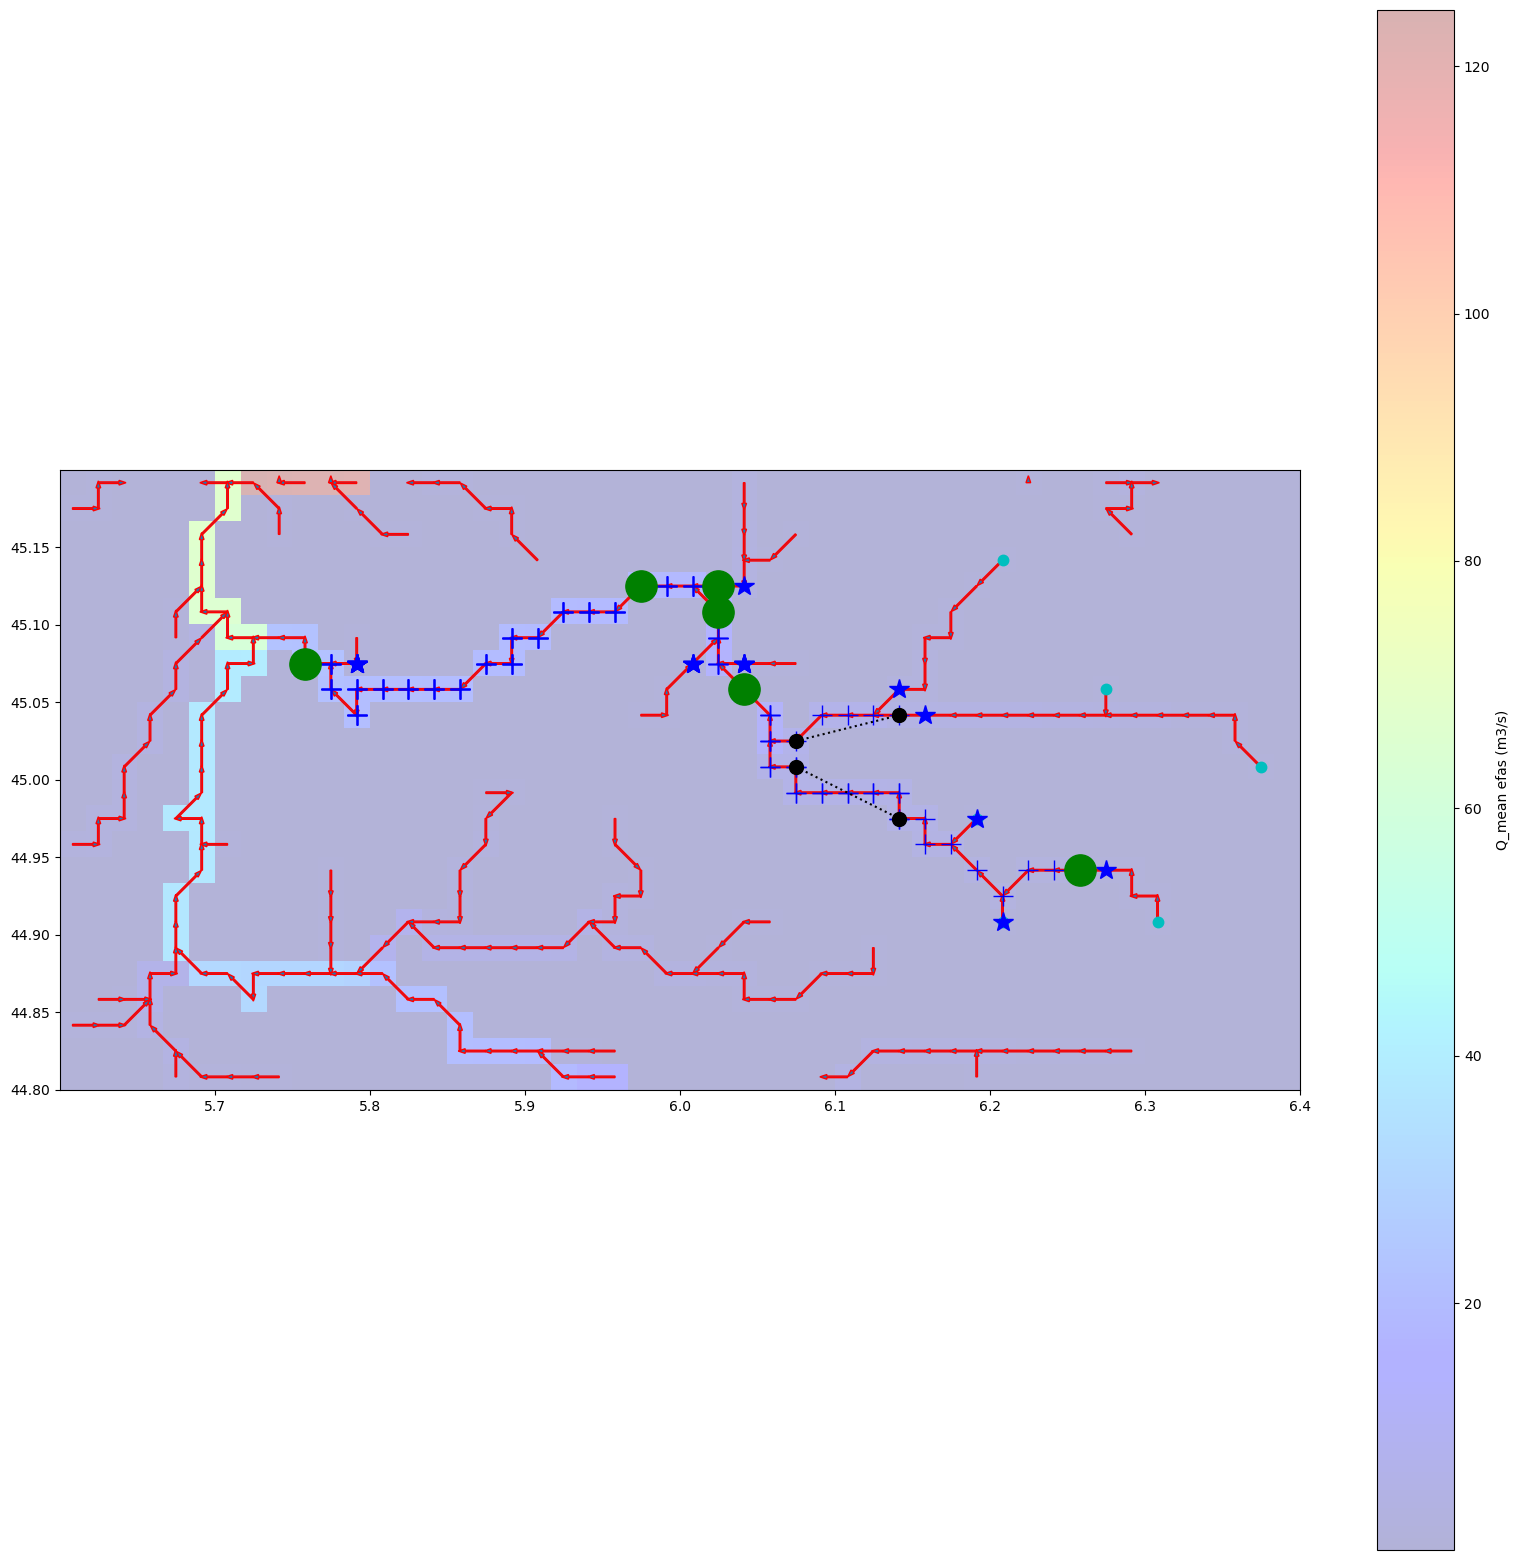

In [13]:
river.define_minimal_flow(f = 0.5)
river.reverse_flow()
river.source((6.041666766437749, 45.058195000000744))
station_veneon_amt = hydroTwin.station(river, transformer93.transform(956468, 6431743)[1], transformer93.transform(956468, 6431743)[0], q_veneon_corr, name = "veneon")
station_bg_oisans = hydroTwin.station(river, transformer93.transform(938985, 6444501)[1], transformer93.transform(938985, 6444501)[0], q_romanche_corr, name = "bourg d'oisans")
station_pont_rouge = hydroTwin.station(river, transformer93.transform(937895, 6450772)[1], transformer93.transform(937895, 6450772)[0], q_pont_rouge_corr, name = "pont rouge")
station_eau_dolle = hydroTwin.station(river, transformer93.transform(937385, 6451343)[1], transformer93.transform(937385, 6451343)[0], q_eau_dolle_corr, name = "eau d'olle")
station_livet = hydroTwin.station(river, transformer93.transform(934072, 6450914)[1], transformer93.transform(934072, 6450914)[0], q_livet_corr, name = "livet")
station_notre_dame_de_mesage = hydroTwin.station(river, transformer93.transform(917537, 6445787)[1], transformer93.transform(917537, 6445787)[0], q_notre_dame_de_mesage_corr, name = "notre dame de mesage")
dam_st_guillerme = hydroTwin.anthropizer(river, 6.07834707032901, 45.0312143985366, do_ecoflow_st_guillerme, up_ecoflow_st_guillerme, up_command= up_command_st_guillerme, do_command= do_command_st_guillerme, up_lon = 6.14363, up_lat = 45.04262)
dam_escoffier = hydroTwin.anthropizer(river, 6.06948774180512, 45.0029729241326, do_ecoflow_escoffier, up_ecoflow_escoffier, do_command = do_command_escoffier, up_lon = 6.14835, up_lat = 44.98094)
river.lowest_natural_flow((station_notre_dame_de_mesage.longitude, station_notre_dame_de_mesage.latitude), [station_bg_oisans, station_veneon_amt, station_livet, station_eau_dolle, station_pont_rouge, station_notre_dame_de_mesage], [dam_escoffier, dam_st_guillerme])
plt.figure(figsize = (20, 20))
river.display_river()
station_veneon_amt.display_station()
station_bg_oisans.display_station()
station_pont_rouge.display_station()
station_eau_dolle.display_station()
station_livet.display_station()
station_notre_dame_de_mesage.display_station()
dam_st_guillerme.display_anthropizer()
dam_escoffier.display_anthropizer()

____________________
station bourg d'oisans :
mean error : -2.1013684200654676
mean error (EFAS) : 13.58110268401056
RMSE : 365.3537354967902
RMSE (EFAS) : 768.0274791130413
____________________
station veneon :
mean error : 3.094836658900479
mean error (EFAS) : 2.7621001230388593
RMSE : 184.71987904941247
RMSE (EFAS) : 177.67892616880127
____________________
station livet :
mean error : -3.5632308481532133
mean error (EFAS) : 15.577372282056901
RMSE : 1066.606837058862
RMSE (EFAS) : 1249.1757117663853
____________________
station eau d'olle :
mean error : 3.935074190027574
mean error (EFAS) : 3.8219778823956907
RMSE : 216.63957617393712
RMSE (EFAS) : 211.4113041919772
____________________
station pont rouge :
mean error : -2.414925388487517
mean error (EFAS) : 15.81830529334281
RMSE : 160.30532466472616
RMSE (EFAS) : 871.4753950287145
____________________
station notre dame de mesage :
mean error : -5.454241975087636
mean error (EFAS) : 10.826389901595633
RMSE : 1005.1742179596985
RMS

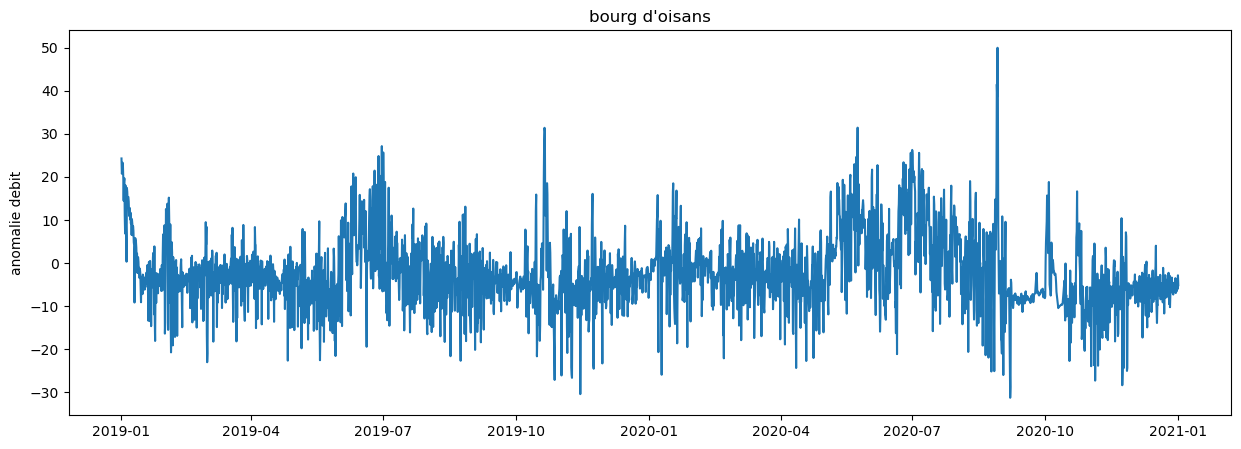

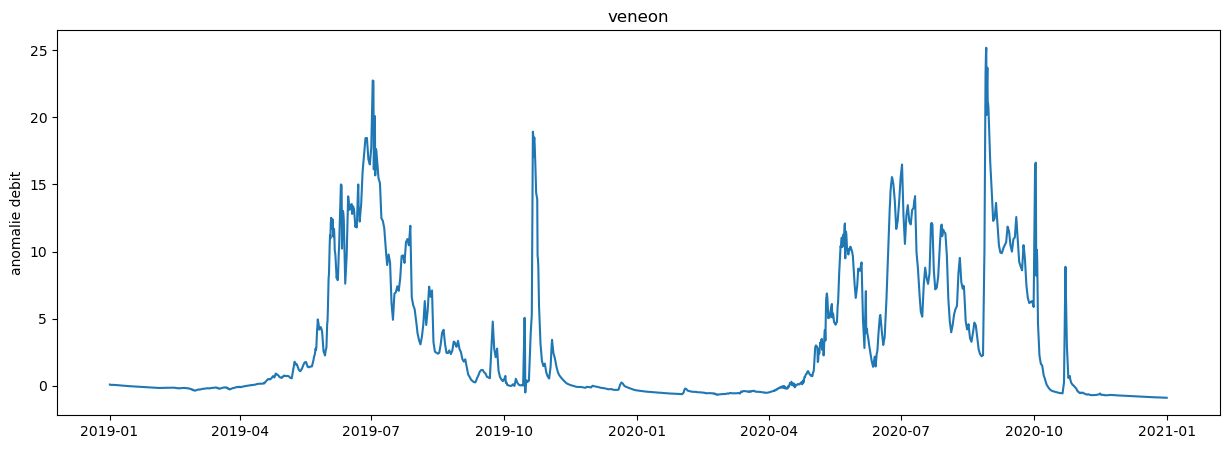

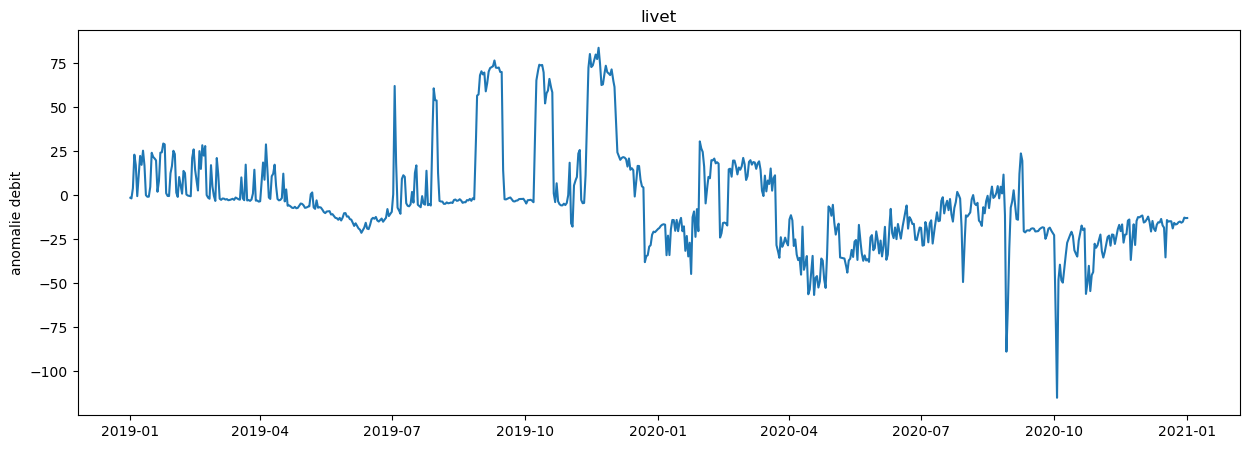

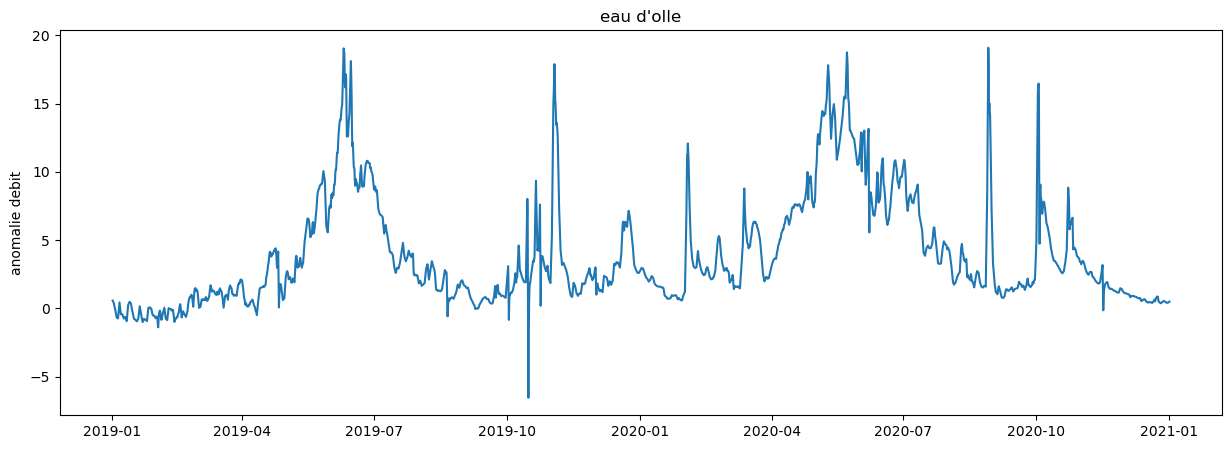

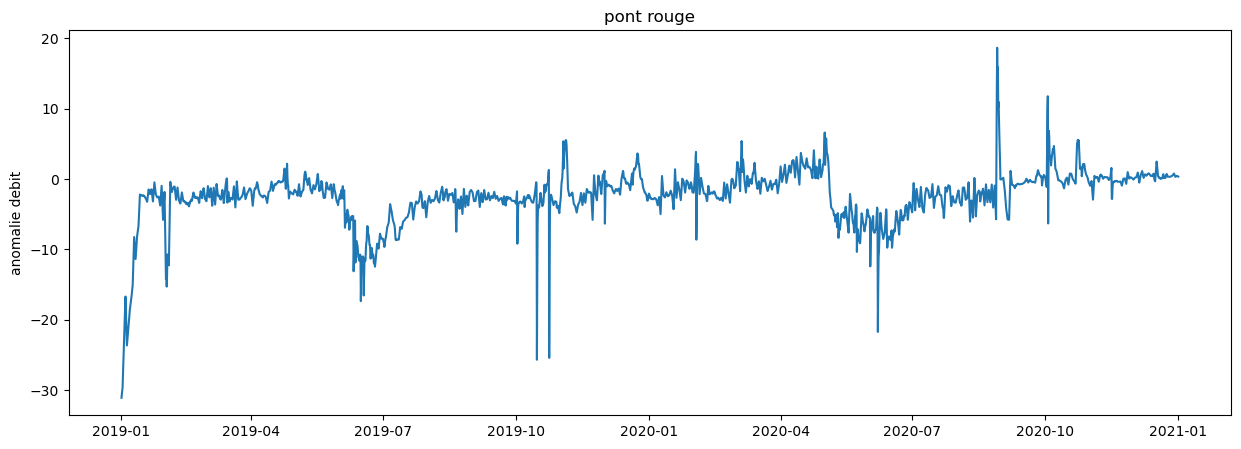

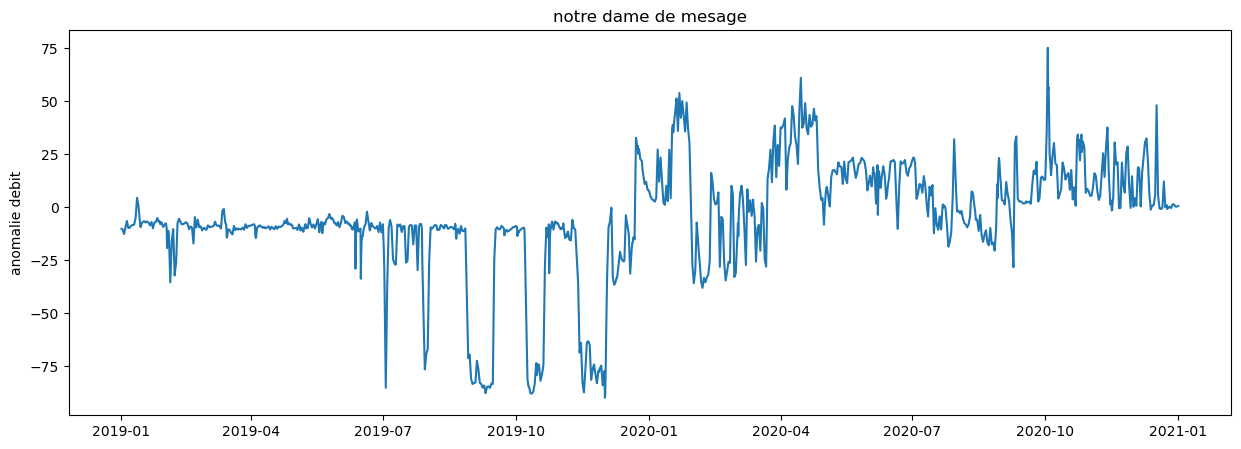

In [14]:
river.simulate([station_bg_oisans, station_veneon_amt, station_livet, station_eau_dolle, station_pont_rouge, station_notre_dame_de_mesage], [dam_escoffier, dam_st_guillerme], (station_notre_dame_de_mesage.longitude, station_notre_dame_de_mesage.latitude), show_error= True)

In [15]:
#tentative de reconstruction du fonctionnement de grand maison

In [16]:
consoCentrales = pd.read_parquet("1900-01-01_2100-01-01_hydro_10min_soutirage.parquet")

In [17]:
do_command_oz = prodCentrales["OZ   H"].resample('6h').mean()
do_command_verney = prodCentrales["VERN7H"].resample('6h').mean()
do_command_gm = prodCentrales["G.MAIH"].resample('6h').mean()
pump_command_gm = consoCentrales["G.MAIHP"].resample('6h').mean()

In [18]:
timestamp = do_command_oz.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, do_command_oz.values, kind='linear', fill_value='extrapolate')
timestamp_new = pd.to_datetime(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1)).astype(np.int64)//10**9

do_command_oz = f_interp(timestamp_new)/13.2*33/0.9

timestamp = do_command_verney.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, do_command_verney.values, kind='linear', fill_value='extrapolate')

do_command_verney = f_interp(timestamp_new)/11*3.7/0.9

timestamp = do_command_gm.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, do_command_gm.values, kind='linear', fill_value='extrapolate')

do_command_gm = f_interp(timestamp_new)/1690*216/0.89

timestamp = pump_command_gm.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, pump_command_gm.values, kind='linear', fill_value='extrapolate')

pump_command_gm = f_interp(timestamp_new)/1280*128/0.85

In [19]:
Q_eau_dolle = pd.read_csv('./debits/eau_dolle_lt.csv')
timestamp = pd.to_datetime(Q_eau_dolle["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_eau_dolle["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')

q_eau_dolle_lt_corr = f_interp(timestamp_new)


In [20]:
loc_gm = (45.20631351188128, 6.117983020926645)
loc_oz = (45.13082433371991, 6.044650287871698)

rep_key = efas.sel(latitude = loc_gm[0], longitude = loc_gm[1], method = 'nearest').dis06.mean().values / efas.sel(latitude = loc_oz[0], longitude = loc_oz[1], method = 'nearest').dis06.mean().values

In [21]:
pump_command_gm

array([9.74539014e+01, 1.01465957e+02, 1.80254139e+01, ...,
       7.92973856e-03, 9.32356754e+00, 7.18101846e+01], shape=(14609,))

In [22]:
volume_gm = [0]
volume_oz = [0]
for t in range(len(q_eau_dolle_lt_corr)) :
    volume_gm.append(volume_gm[-1] + ( - do_command_gm[t] + pump_command_gm[t] - max(0.17, do_command_verney[t]) + rep_key*q_eau_dolle_lt_corr[t])*3600*6)
    volume_oz.append(volume_oz[-1] + (do_command_gm[t] - pump_command_gm[t] + max(0.17, do_command_verney[t]) + (1 - rep_key)*q_eau_dolle_lt_corr[t] - do_command_oz[t])*3600*6)

In [23]:
corr_oz = np.polyfit(np.array(timestamp_new), np.array(volume_oz[:-1]), 2)
corr_gm = np.polyfit(np.array(timestamp_new), np.array(volume_gm[:-1]), 2)

In [24]:
volume_oz_corr =  volume_oz[:-1] - (corr_oz[2] + corr_oz[1]*timestamp_new + corr_oz[0]*timestamp_new**2)
volume_gm_corr = volume_gm[:-1] - (corr_gm[2] + corr_gm[1]*timestamp_new + corr_gm[0]*timestamp_new**2)

Text(0, 0.5, 'volume (m3)')

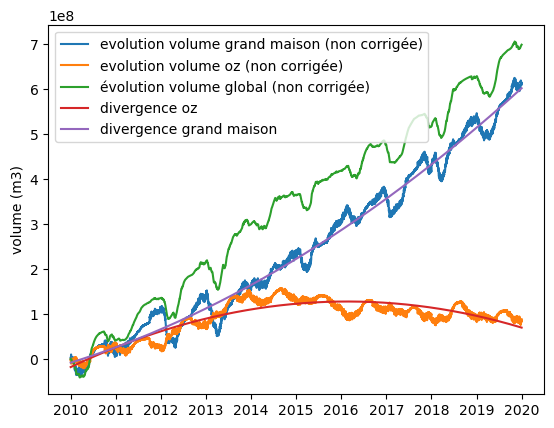

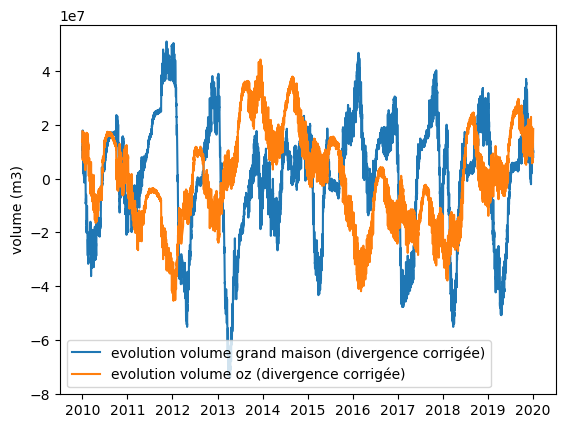

In [25]:
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_gm[:-1])
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_oz[:-1])
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), np.array(volume_oz[:-1]) + np.array(volume_gm[:-1]))
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), corr_oz[2] + corr_oz[1]*timestamp_new + corr_oz[0]*timestamp_new**2)
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), corr_gm[2] + corr_gm[1]*timestamp_new + corr_gm[0]*timestamp_new**2)
plt.legend(["evolution volume grand maison (non corrigée)", "evolution volume oz (non corrigée)", "évolution volume global (non corrigée)", "divergence oz", "divergence grand maison"])
plt.ylabel("volume (m3)")
plt.figure()
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_gm_corr)
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_oz_corr)
plt.legend(["evolution volume grand maison (divergence corrigée)", "evolution volume oz (divergence corrigée)"])
plt.ylabel("volume (m3)")

Text(0, 0.5, 'volume (m3)')

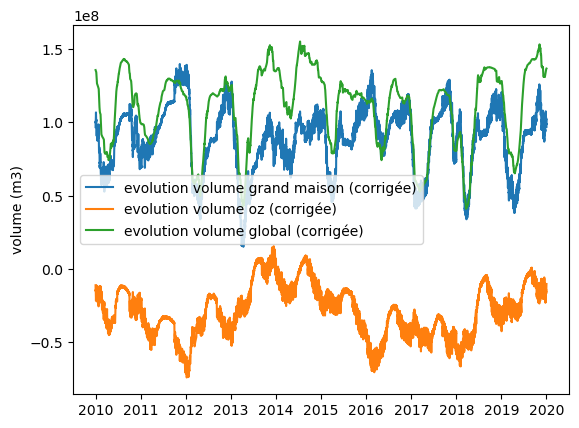

In [26]:
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_gm_corr - max(volume_gm_corr) + 140e6)
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_oz_corr - max(volume_oz_corr) + 15.4e6)
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_oz_corr - max(volume_oz_corr + volume_gm_corr) + 15.4e6 + volume_gm_corr + 140e6)

plt.legend(["evolution volume grand maison (corrigée)", "evolution volume oz (corrigée)", "evolution volume global (corrigée)"])
plt.ylabel("volume (m3)")

In [27]:
fftOz = scipy.fft.fft(volume_oz_corr - max(volume_oz_corr) + 15.4e6)
amplitudes = np.abs(fftOz)
indices_principaux = np.argsort(amplitudes)[-12:]  
indice_principal = np.argsort(amplitudes)[-3:]  

coeffs_trunc = np.zeros_like(fftOz)
coeffs_trunc[indices_principaux] = fftOz[indices_principaux]
y_reconstruit = np.real(scipy.fft.ifft(coeffs_trunc))

coeffs_trunc = np.zeros_like(fftOz)
coeffs_trunc[indice_principal] = fftOz[indice_principal]
y_reconstruit_one = np.real(scipy.fft.ifft(coeffs_trunc))

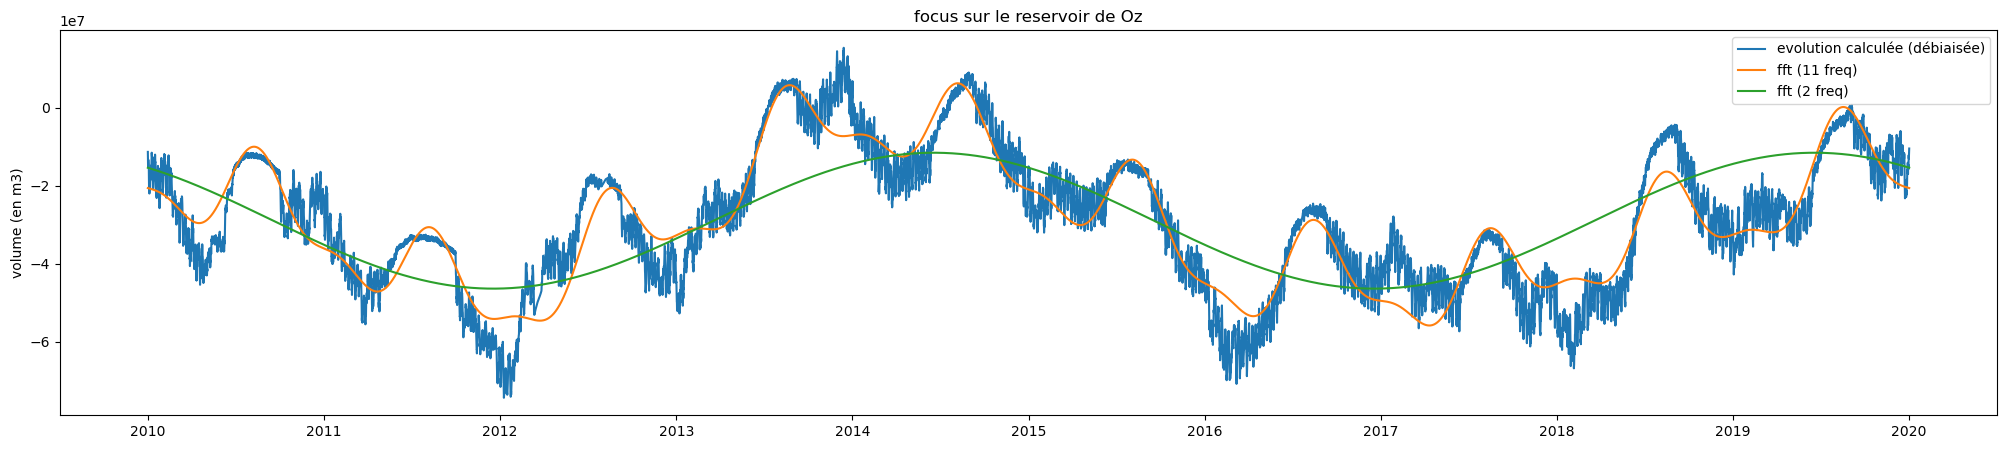

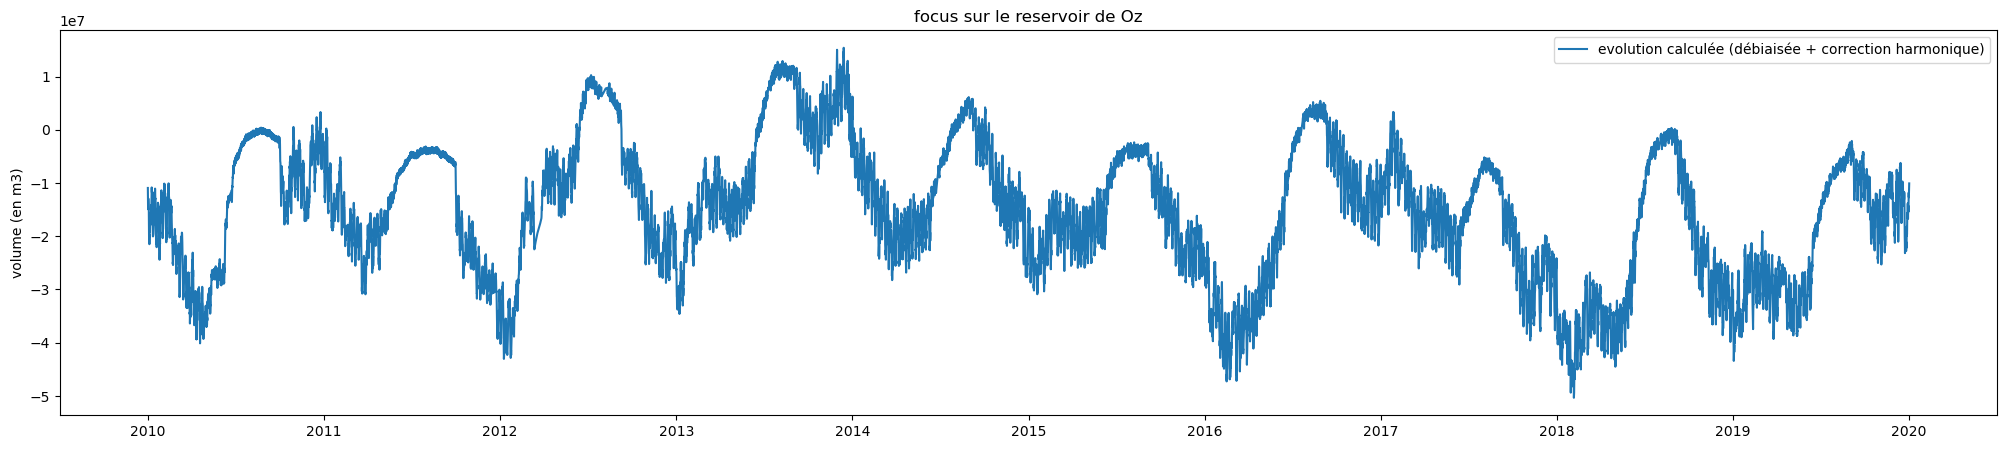

In [28]:
plt.figure(figsize = (25, 5))
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_oz_corr - max(volume_oz_corr) + 15.4e6)
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), y_reconstruit)
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), y_reconstruit_one)
plt.title("focus sur le reservoir de Oz")
plt.ylabel("volume (en m3)")
plt.legend(["evolution calculée (débiaisée)", "fft (11 freq)", "fft (2 freq)"])
plt.figure(figsize = (25, 5))
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_oz_corr - y_reconstruit_one - max(volume_oz_corr - y_reconstruit_one) + 15.4e6)
plt.title("focus sur le reservoir de Oz")
plt.ylabel("volume (en m3)")
plt.legend(["evolution calculée (débiaisée + correction harmonique)"])

In [29]:
fftGM = scipy.fft.fft(volume_gm_corr - max(volume_gm_corr) + 140e6)
amplitudes = np.abs(fftGM)
indices_principaux = np.argsort(amplitudes)[-12:]  
indice_principal = np.argsort(amplitudes)[-3:]  

coeffs_trunc = np.zeros_like(fftGM)
coeffs_trunc[indices_principaux] = fftGM[indices_principaux]
y_reconstruit = np.real(scipy.fft.ifft(coeffs_trunc))

coeffs_trunc = np.zeros_like(fftGM)
coeffs_trunc[indice_principal] = fftGM[indice_principal]
y_reconstruit_one = np.real(scipy.fft.ifft(coeffs_trunc))

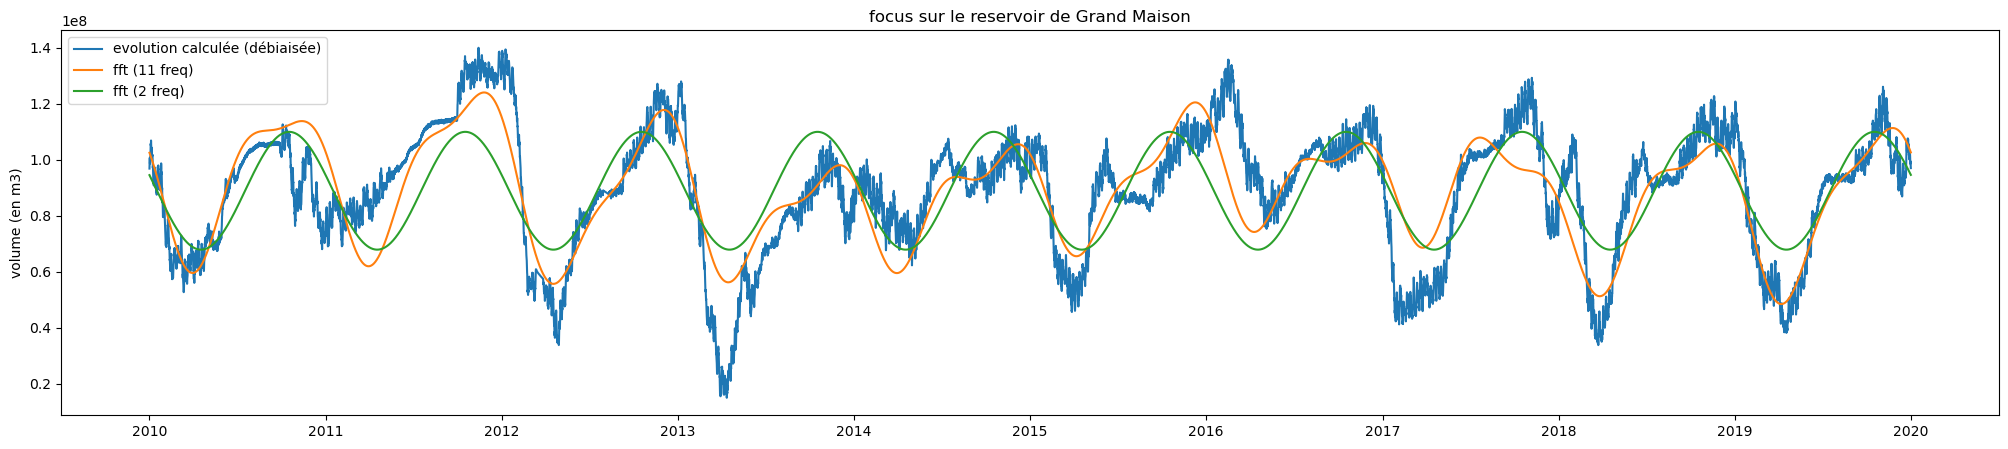

In [30]:
plt.figure(figsize = (25, 5))
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_gm_corr - max(volume_gm_corr) + 140e6)
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), y_reconstruit)
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), y_reconstruit_one)
plt.title("focus sur le reservoir de Grand Maison")
plt.ylabel("volume (en m3)")
plt.legend(["evolution calculée (débiaisée)", "fft (11 freq)", "fft (2 freq)"])


In [31]:
do_command_oz = prodCentrales["OZ   H"].resample('6h').mean()
do_command_verney = prodCentrales["VERN7H"].resample('6h').mean()
do_command_gm = prodCentrales["G.MAIH"].resample('6h').mean()
pump_command_gm = consoCentrales["G.MAIHP"].resample('6h').mean()

In [32]:
timestamp = do_command_oz.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, do_command_oz, kind='linear', fill_value='extrapolate')
timestamp_new = pd.to_datetime(np.linspace(datetime.datetime(2013, 1, 1), datetime.datetime(2019, 1, 1), (datetime.datetime(2019, 1, 1) - datetime.datetime(2013, 1, 1)).days * 4 + 1)).astype(np.int64)//10**9

do_command_oz = f_interp(timestamp_new)/13.2*33/0.9

timestamp = do_command_verney.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, do_command_verney, kind='linear', fill_value='extrapolate')

do_command_verney = f_interp(timestamp_new)/11*3.7/0.9

timestamp = do_command_gm.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, do_command_gm, kind='linear', fill_value='extrapolate')

do_command_gm = f_interp(timestamp_new)/1690*216/0.9

timestamp = pump_command_gm.index.astype(np.int64)//10**9
f_interp = interp1d(timestamp, pump_command_gm, kind='linear', fill_value='extrapolate')

pump_command_gm = f_interp(timestamp_new)/1280*128/0.9

In [33]:
Q_eau_dolle = pd.read_csv('./debits/eau_dolle_lt.csv')
timestamp = pd.to_datetime(Q_eau_dolle["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_eau_dolle["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')

q_eau_dolle_lt_corr = f_interp(timestamp_new)

In [34]:
Q_pont_rouge = pd.read_csv('./debits/pont_rouge_lt.csv')
timestamp = pd.to_datetime(Q_pont_rouge["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_pont_rouge["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')

q_pont_rouge_lt_corr = f_interp(timestamp_new)

Q_livet = pd.read_csv('./debits/livet_lt.csv')
timestamp = pd.to_datetime(Q_livet["Date (TU)"]).astype(np.int64)//10**9
f_interp = interp1d(timestamp, Q_livet["Valeur (en m³/s)"], kind='linear', fill_value='extrapolate')

q_livet_lt_corr = f_interp(timestamp_new)

In [35]:
do_command_oz_flowbased = q_livet_lt_corr - q_pont_rouge_lt_corr


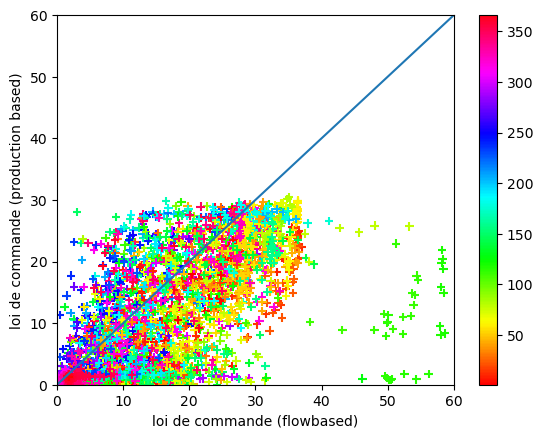

In [36]:
cm = plt.scatter(do_command_oz_flowbased, do_command_oz, c = pd.to_datetime(timestamp_new *10**9).day_of_year, marker = '+', cmap = "hsv")
plt.xlabel("loi de commande (flowbased)")
plt.ylabel("loi de commande (production based)")
plt.colorbar(cm)
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.plot([0, 60], [0, 60])

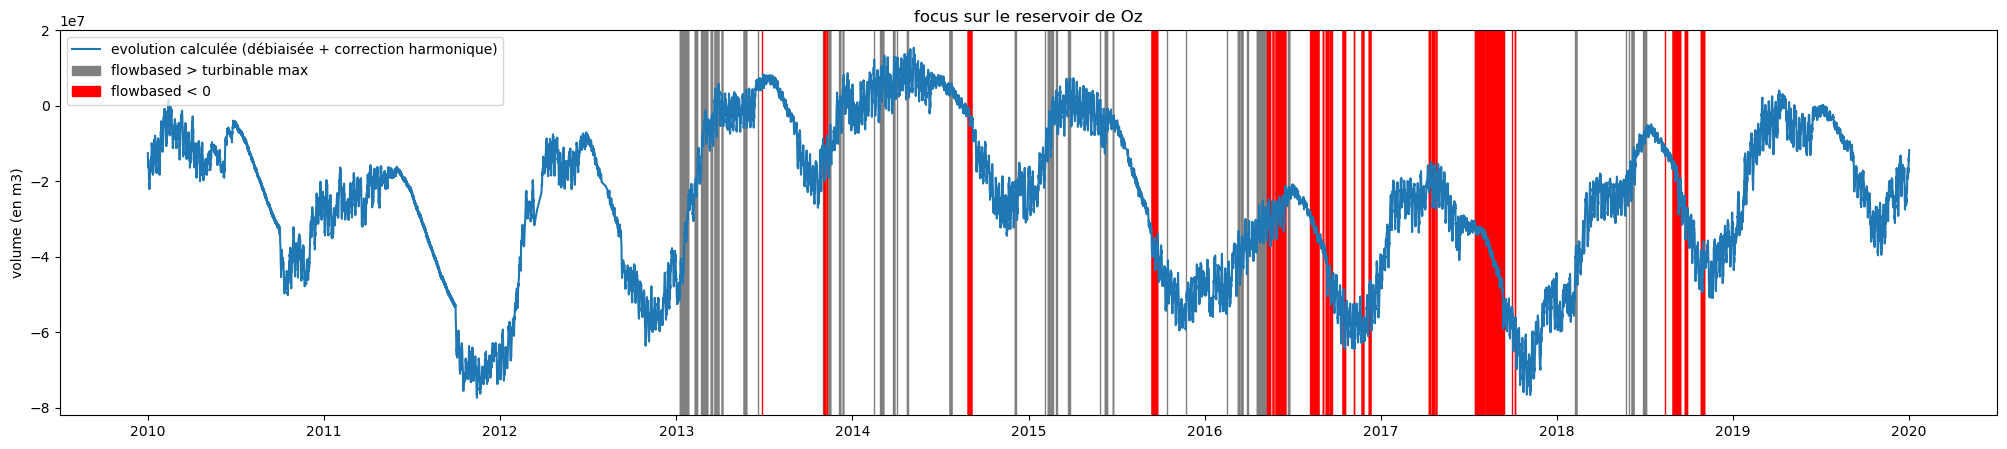

In [37]:
plt.figure(figsize = (25, 5))
plt.plot(np.linspace(datetime.datetime(2010, 1, 1), datetime.datetime(2020, 1, 1), (datetime.datetime(2020, 1, 1) - datetime.datetime(2010, 1, 1)).days * 4 + 1), volume_oz_corr - y_reconstruit_one - max(volume_oz_corr - y_reconstruit_one) + 15.4e6, label = "evolution calculée (débiaisée + correction harmonique)")
plt.title("focus sur le reservoir de Oz")
plt.ylabel("volume (en m3)")

for d in pd.to_datetime(timestamp_new *10**9)[do_command_oz_flowbased > 30]:
    plt.axvspan(d - pd.Timedelta(hours=3), d + pd.Timedelta(hours=3), color='grey', alpha=1)
plt.axvspan(d - pd.Timedelta(hours=3), d + pd.Timedelta(hours=3), color='grey', alpha=1, label = 'flowbased > turbinable max')

for d in pd.to_datetime(timestamp_new *10**9)[do_command_oz_flowbased < 0]:
    plt.axvspan(d - pd.Timedelta(hours=3), d + pd.Timedelta(hours=3), color='red', alpha=1)
plt.axvspan(d - pd.Timedelta(hours=3), d + pd.Timedelta(hours=3), color='red', alpha=1, label = 'flowbased < 0')

plt.legend()

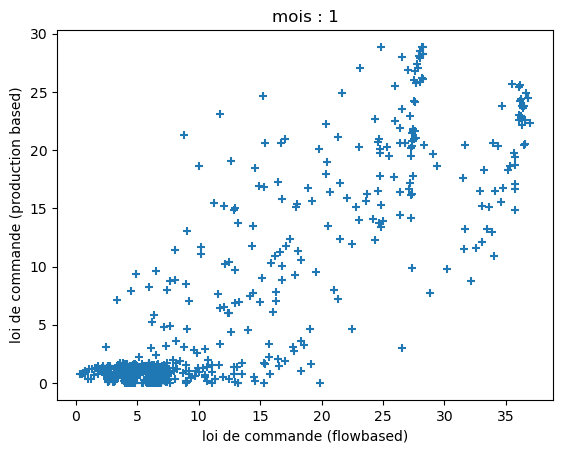

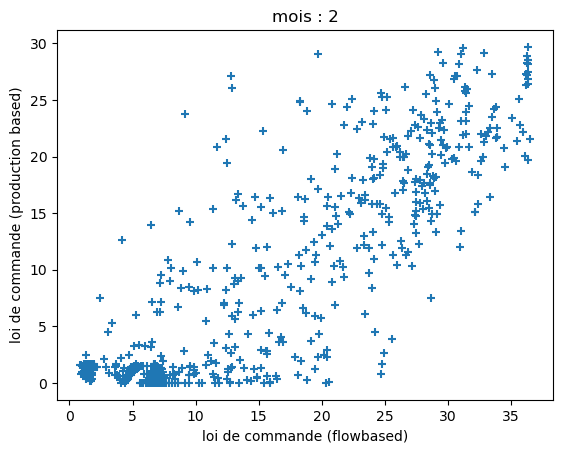

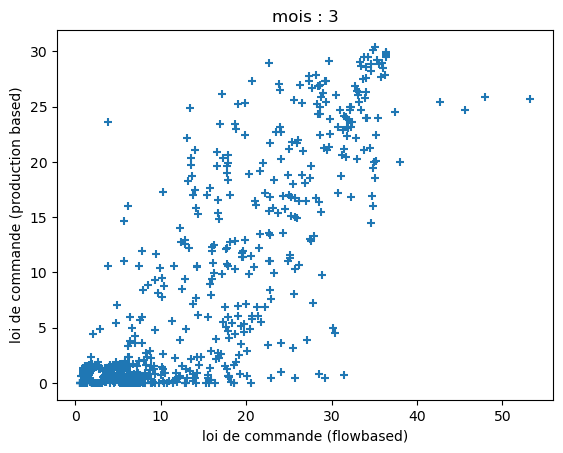

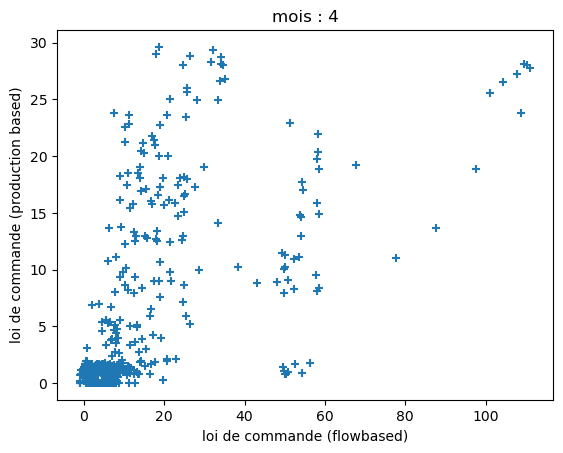

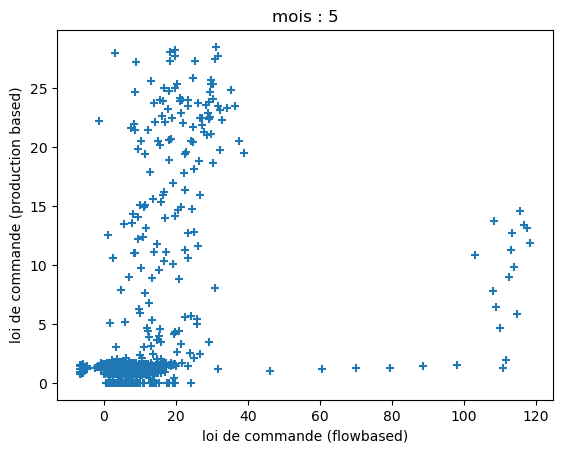

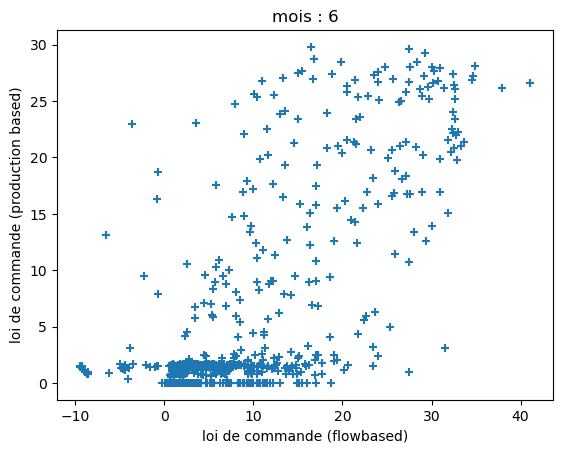

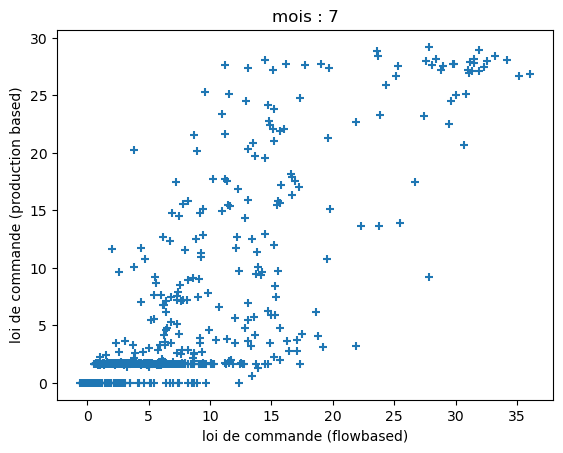

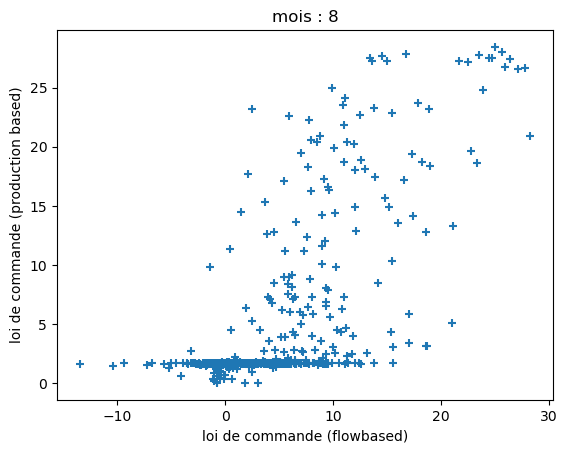

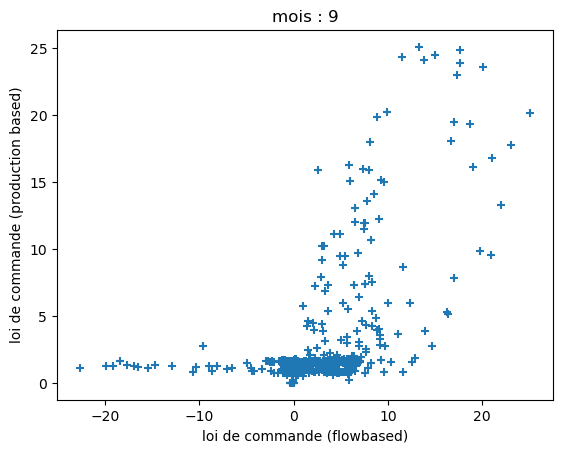

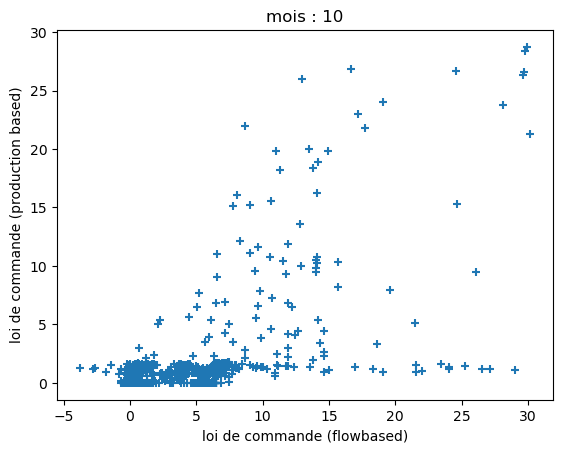

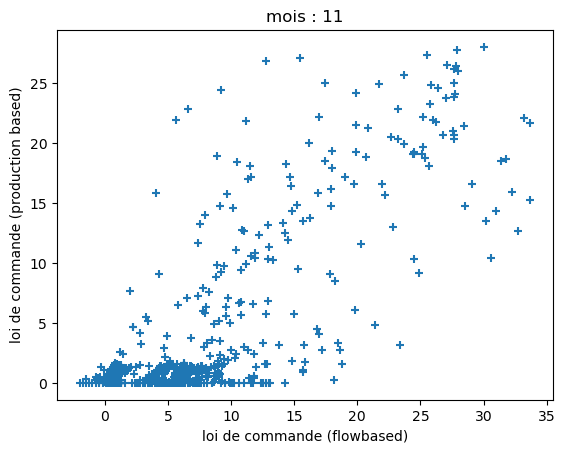

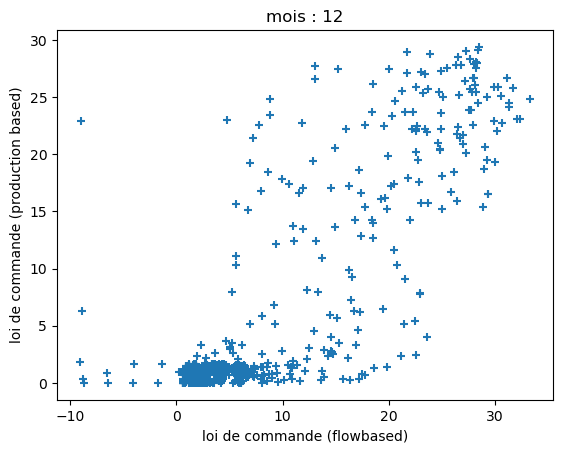

In [38]:
for i in range(1, 13) :
    plt.figure()
    plt.scatter(do_command_oz_flowbased[pd.to_datetime(timestamp_new *10**9).month == i], do_command_oz[pd.to_datetime(timestamp_new *10**9).month == i], marker = '+')
    plt.title("mois : " + str(i))
    plt.xlabel("loi de commande (flowbased)")
    plt.ylabel("loi de commande (production based)")

In [39]:
rep_key = 0.15
do_command_oz_flowbased = np.maximum(0, do_command_oz_flowbased)

In [40]:
volume_gm = [0]
volume_oz = [0]
for t in range(len(q_eau_dolle_lt_corr)) :
    volume_gm.append(volume_gm[-1] + ( - do_command_gm[t] + pump_command_gm[t] - max(0.17, do_command_verney[t]) + rep_key*q_eau_dolle_lt_corr[t])*3600*6)
    volume_oz.append(volume_oz[-1] + (do_command_gm[t] - pump_command_gm[t] + max(0.17, do_command_verney[t]) + (1 - rep_key)*q_eau_dolle_lt_corr[t] - do_command_oz_flowbased[t])*3600*6)

Text(0, 0.5, 'volume (m3)')

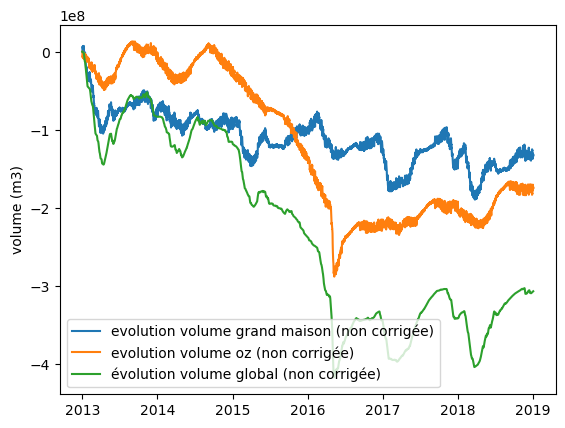

In [41]:
plt.plot(np.linspace(datetime.datetime(2013, 1, 1), datetime.datetime(2019, 1, 1), (datetime.datetime(2019, 1, 1) - datetime.datetime(2013, 1, 1)).days * 4 + 1), volume_gm[:-1])
plt.plot(np.linspace(datetime.datetime(2013, 1, 1), datetime.datetime(2019, 1, 1), (datetime.datetime(2019, 1, 1) - datetime.datetime(2013, 1, 1)).days * 4 + 1), volume_oz[:-1])
plt.plot(np.linspace(datetime.datetime(2013, 1, 1), datetime.datetime(2019, 1, 1), (datetime.datetime(2019, 1, 1) - datetime.datetime(2013, 1, 1)).days * 4 + 1), np.array(volume_oz[:-1]) + np.array(volume_gm[:-1]))
plt.legend(["evolution volume grand maison (non corrigée)", "evolution volume oz (non corrigée)", "évolution volume global (non corrigée)"
            ])
plt.ylabel("volume (m3)")


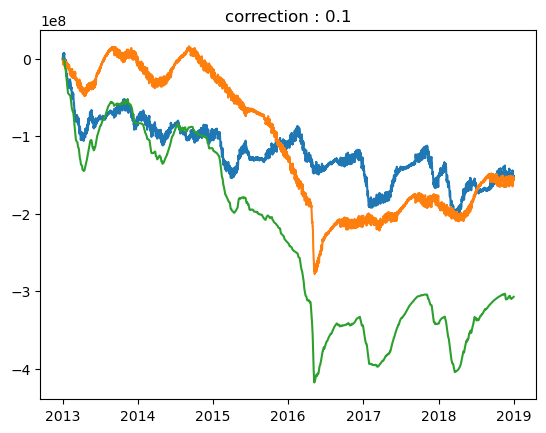

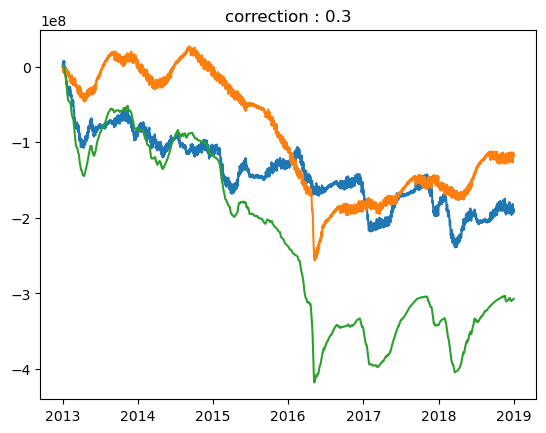

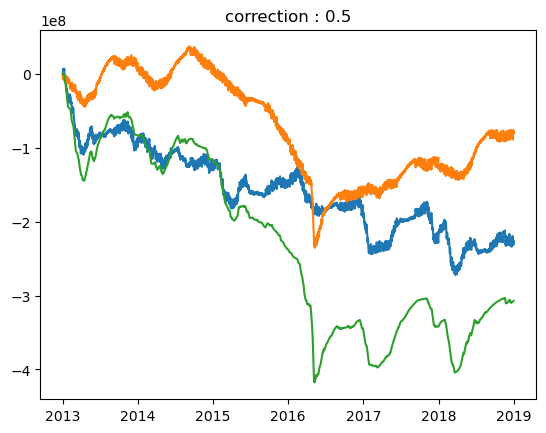

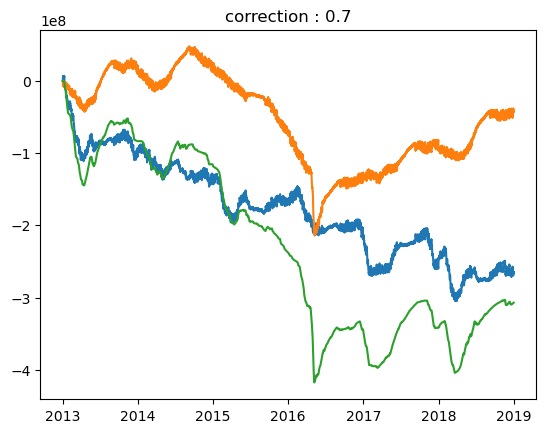

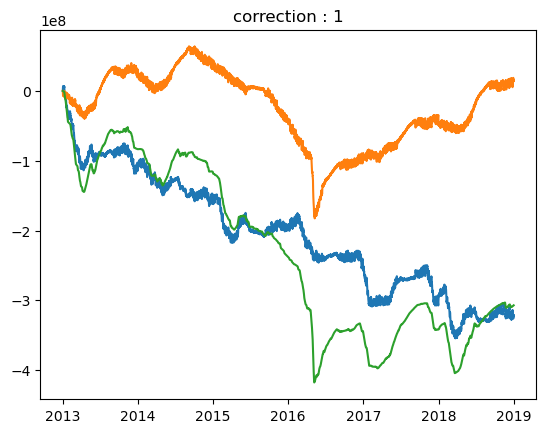

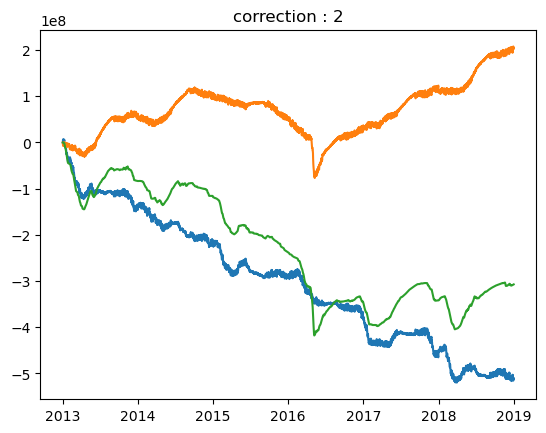

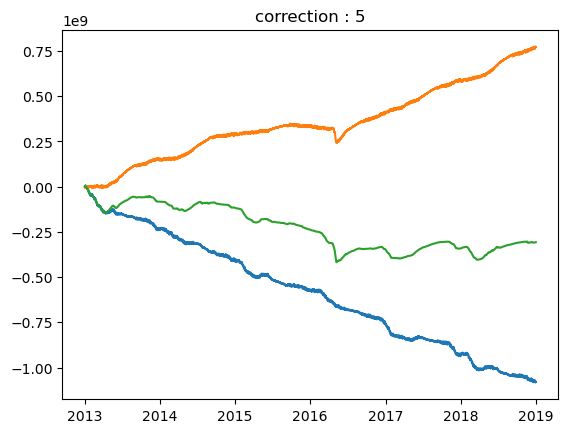

In [42]:

for corr in [0.1, 0.3, 0.5, 0.7, 1, 2, 5] :
    volume_gm = [0]
    volume_oz = [0]
    for t in range(len(q_eau_dolle_lt_corr)) :
        volume_gm.append(volume_gm[-1] + ( - do_command_gm[t] + pump_command_gm[t] - max(0.17, do_command_verney[t]) + rep_key*q_eau_dolle_lt_corr[t] - corr)*3600*6)
        volume_oz.append(volume_oz[-1] + (do_command_gm[t] - pump_command_gm[t] + max(0.17, do_command_verney[t]) + (1 - rep_key)*q_eau_dolle_lt_corr[t] - do_command_oz_flowbased[t] + corr)*3600*6)
    plt.figure()
    plt.plot(np.linspace(datetime.datetime(2013, 1, 1), datetime.datetime(2019, 1, 1), (datetime.datetime(2019, 1, 1) - datetime.datetime(2013, 1, 1)).days * 4 + 1), volume_gm[:-1])
    plt.plot(np.linspace(datetime.datetime(2013, 1, 1), datetime.datetime(2019, 1, 1), (datetime.datetime(2019, 1, 1) - datetime.datetime(2013, 1, 1)).days * 4 + 1), volume_oz[:-1])
    plt.plot(np.linspace(datetime.datetime(2013, 1, 1), datetime.datetime(2019, 1, 1), (datetime.datetime(2019, 1, 1) - datetime.datetime(2013, 1, 1)).days * 4 + 1), np.array(volume_oz[:-1]) + np.array(volume_gm[:-1]))
    plt.title("correction : " + str(corr))

In [43]:
##comparaison avec la mesure directe de SWOT

In [44]:
volume_gm = [0]
do_command_verney = prodCentrales["VERN7H"].resample('6h').mean()/11*3.7/0.9
do_command_gm = prodCentrales["G.MAIH"].resample('6h').mean()/1690*216/0.9
pump_command_gm = consoCentrales["G.MAIHP"].resample('6h').mean()/1280*128/0.9

for t in range(len(do_command_gm)) :
    volume_gm.append(volume_gm[-1] + ( - do_command_gm[t] + pump_command_gm[t] - max(0.17, do_command_verney[t]))*3600*6)

C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\546395799.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  volume_gm.append(volume_gm[-1] + ( - do_command_gm[t] + pump_command_gm[t] - max(0.17, do_command_verney[t]))*3600*6)


In [45]:
listFiles = os.listdir("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m STEP/")

transformer31 = Transformer.from_crs("EPSG:4326", "EPSG:32631") 
transformer32 = Transformer.from_crs("EPSG:4326", "EPSG:32632")

upperLeft = (45.17740885860838, 6.090313206519888) 
lowerRight = (45.23627164874456, 6.1575001966826814) 

gdf = gpd.read_file("./GDW_v1_0_shp/GDW_reservoirs_v1_0.shp")
filtered = gdf[gdf["DAM_NAME"] == "Grand Maison"]

In [46]:
for file in listFiles :
    if '.nc' == file[-3:] :
        if file.split('_')[5] == 'UTM31T':
            (xmin, ymin) = transformer31.transform(upperLeft[0], upperLeft[1])
            (xmax, ymax) = transformer31.transform(lowerRight[0], lowerRight[1])
            temp = xr.open_dataset("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m STEP/" + file)
            tempReduced = temp["wse"].where((temp.x > xmin) & (temp.x < xmax) & (temp.y > ymin) & (temp.y < ymax), drop = True)
            X, Y = np.meshgrid(tempReduced.x.values, tempReduced.y.values)
            pts = [Point(x, y) for x, y in zip(X.flatten(), Y.flatten())]
            polygon = filtered.to_crs(epsg=32631).iloc[0].geometry
            mask = [polygon.contains(pt) for pt in pts]
            
            X_in_31 = X.flatten()[mask]
            Y_in_31 = Y.flatten()[mask]
            break 

for file in listFiles :
    if '.nc' == file[-3:] :
        if file.split('_')[5] == 'UTM32T':
            (xmin, ymin) = transformer32.transform(upperLeft[0], upperLeft[1])
            (xmax, ymax) = transformer32.transform(lowerRight[0], lowerRight[1])
            temp = xr.open_dataset("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m STEP/" + file)
            tempReduced = temp["wse"].where((temp.x > xmin) & (temp.x < xmax) & (temp.y > ymin) & (temp.y < ymax), drop = True)
            X, Y = np.meshgrid(tempReduced.x.values, tempReduced.y.values)
            pts = [Point(x, y) for x, y in zip(X.flatten(), Y.flatten())]
            polygon = filtered.to_crs(epsg=32632).iloc[0].geometry
            mask = [polygon.contains(pt) for pt in pts]
            
            X_in_32 = X.flatten()[mask]
            Y_in_32 = Y.flatten()[mask]
            break 

In [47]:
date = [] #permet de recalculer les altimetrie du lac
level = []
uncert = []
hr = []
for file in tqdm(listFiles) :
    if '.nc' == file[-3:] :
        if file.split('_')[5] == 'UTM31T':
            X_lake = X_in_31
            Y_lake = Y_in_31
        else :
            X_lake = X_in_32
            Y_lake = Y_in_32
        temp = xr.open_dataset("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m STEP/" + file)
        date.append(datetime.datetime.strptime(file.split("_")[14], "%Y%m%dT%H%M%S"))
        wseList = []
        uncertList = []
        for x_i, y_i in zip(X_lake, Y_lake) :
            wseList.append(temp.sel(x = x_i, y = y_i, method = "nearest").wse.values)
            uncertList.append(temp.sel(x = x_i, y = y_i, method = "nearest").wse_uncert.values)
            if (wseList[-1] > 1695) | (wseList[-1] < 1590) :
                wseList = wseList[:-1]
                uncertList = uncertList[:-1]
        level.append(np.nanmean(np.array(wseList)))
        uncert.append(np.nanmax(np.array(uncertList)))
        hr.append(datetime.datetime.strptime(file.split("_")[13], "%Y%m%dT%H%M%S"))

  1%|          | 41/4196 [00:03<05:07, 13.53it/s]C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1693213459.py:23: RuntimeWarning: Mean of empty slice
  level.append(np.nanmean(np.array(wseList)))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1693213459.py:24: RuntimeWarning: All-NaN slice encountered
  uncert.append(np.nanmax(np.array(uncertList)))
  1%|▏         | 53/4196 [00:04<05:08, 13.44it/s]C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1693213459.py:23: RuntimeWarning: Mean of empty slice
  level.append(np.nanmean(np.array(wseList)))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1693213459.py:24: RuntimeWarning: All-NaN slice encountered
  uncert.append(np.nanmax(np.array(uncertList)))
  2%|▏         | 89/4196 [00:06<04:41, 14.57it/s]C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1693213459.py:23: RuntimeWarning: Mean of empty slice
  level.append(np.nanmean(np.array(wseList)))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\16932

In [48]:
color = []
for h in hr :
    color.append(h.hour)

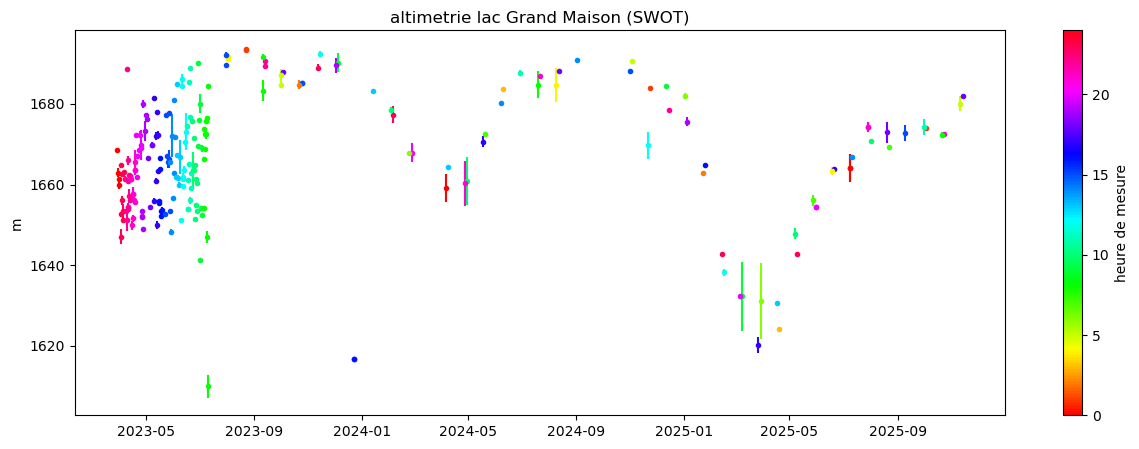

In [49]:
fig, ax = plt.subplots(figsize = (15, 5))
for d, l, u, c in zip(date, level, uncert, color) : 
    ax.errorbar(d, l, yerr= u, color = plt.get_cmap("hsv")(c/24), fmt = ".")
plt.title("altimetrie lac Grand Maison (SWOT)")
ax.set_ylabel("m")

norm = plt.Normalize(vmin=0, vmax=24)
sm = ScalarMappable(norm=norm, cmap=plt.get_cmap("hsv"))
plt.colorbar(sm, ax = ax, label='heure de mesure')

In [50]:
df_level = pd.DataFrame(np.array([date, level]).T, columns=('date', 'level'))
df_var = pd.DataFrame(np.array([do_command_gm.index, volume_gm[1:]]).T, columns= ('date', 'var'))
df_level = df_level.dropna()

In [51]:
df_level["date"] = df_level["date"].dt.tz_localize('UTC')
df_level = df_level.sort_values(by = ["date"])
df_level = df_level.reset_index(drop=True)

Text(0.5, 1.0, 'grand maison')

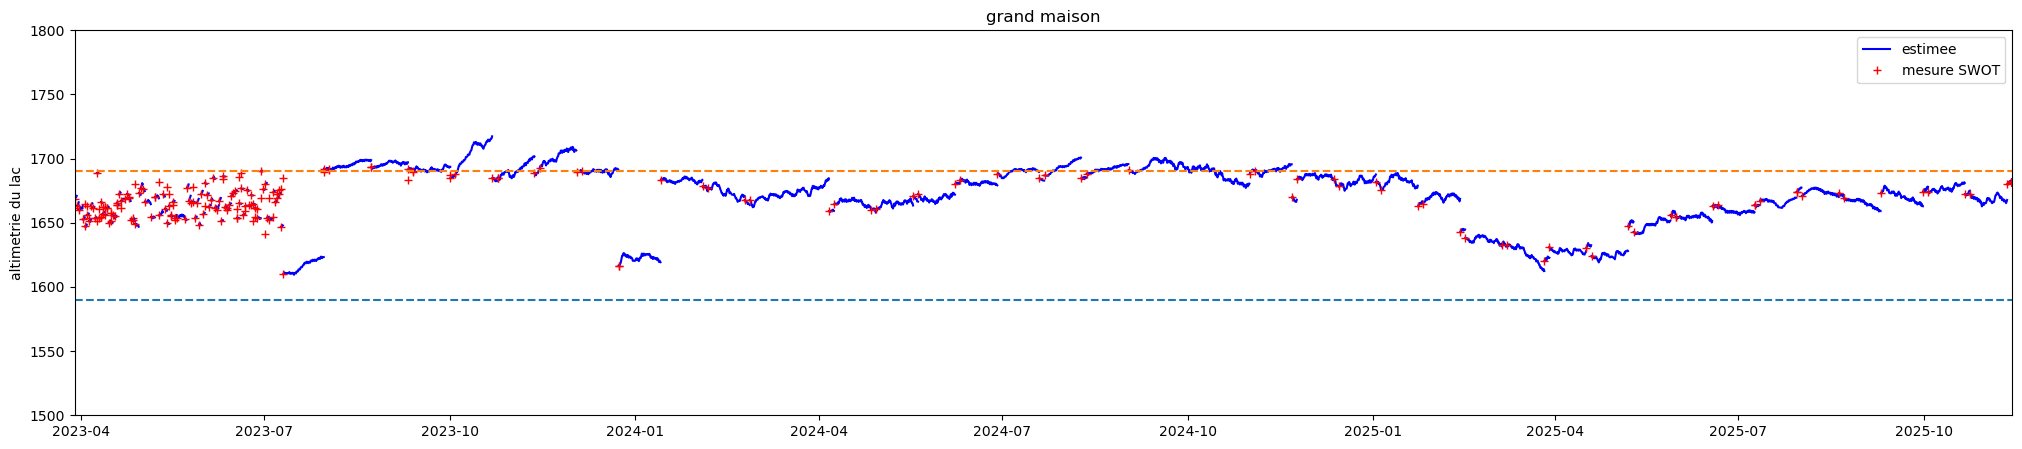

In [52]:
i = 0

l = []
t = []
corr = 0
corr_list = []
t_corr_gm = []
plt.figure(figsize=(25, 5))

for d, var in zip(df_var['date'], df_var['var']) :
    if d < df_level['date'][i] :
        l.append(var/140e6*100 + corr)
        t.append(d)
    else :
        plt.plot(t, l, 'b')
        plt.plot(t[0], l[0], 'r+')
        
        l = [df_level["level"][i]]
        t = [df_level["date"][i]]
        corr = df_level["level"][i] - var/140e6*100
        t_corr_gm.append(df_level["date"][i])
        if i + 1 < len(df_level["date"]):
            i += 1

plt.plot([df_level["date"][0], list(df_level["date"])[-1]], [1590, 1590], '--')  
plt.plot([df_level["date"][0], list(df_level["date"])[-1]], [1690, 1690], '--')       
plt.xlim(df_level["date"][0], list(df_level["date"])[-1])
plt.ylim(1500, 1800)
plt.ylabel("altimetrie du lac")
plt.legend(["estimee", "mesure SWOT"])
plt.title("grand maison")

Text(0.5, 1.0, 'grand maison')

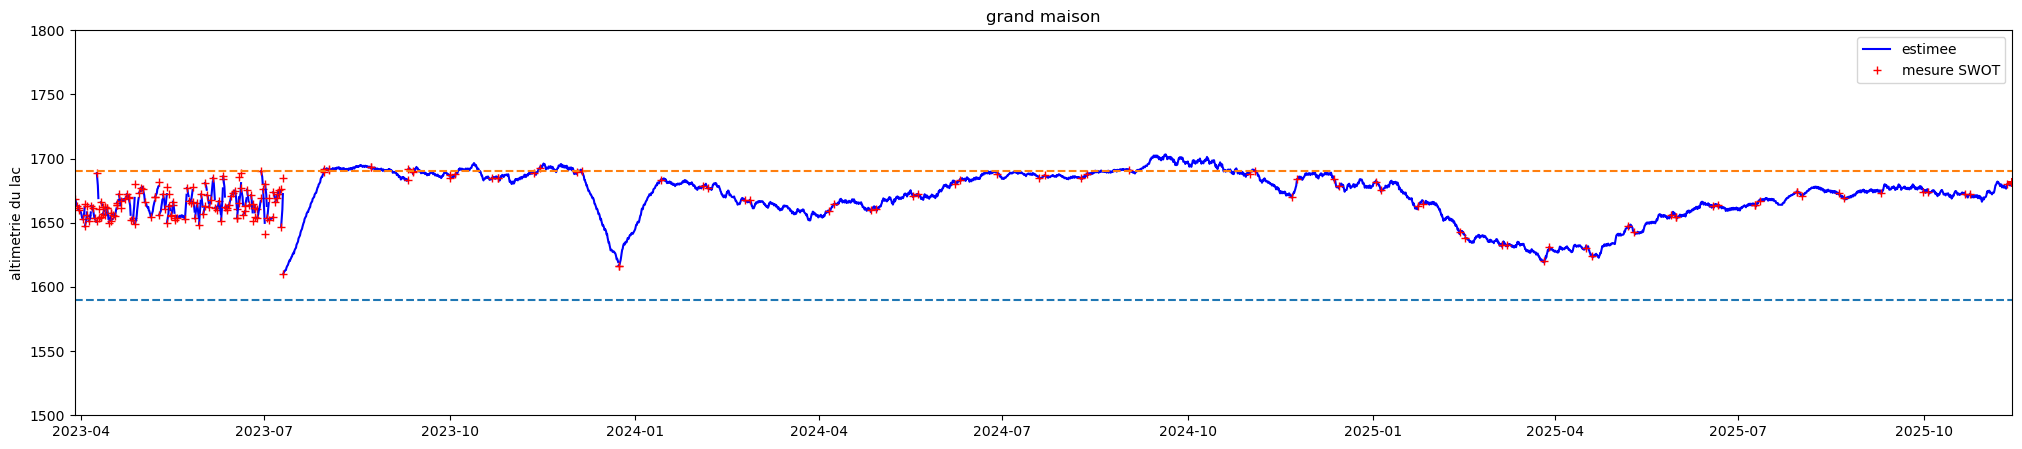

In [53]:
i = 0

l = []
t = []
corr = 0
corr_list_gm = []
plt.figure(figsize=(25, 5))

for d, var in zip(df_var['date'], df_var['var']) :
    if d < df_level['date'][i] :
        l.append(var/140e6*100 + corr)
        t.append(d)
    else :
        plt.plot(t, l - (corr - df_level["level"][i] + var/140e6*100) * np.arange(0, len(t), 1)/len(t), 'b')
        plt.plot(t[0], l[0], 'r+')
        corr_list_gm.append(corr - df_level["level"][i] + var/140e6*100)
        
        l = [df_level["level"][i]]
        t = [df_level["date"][i]]
        corr = df_level["level"][i] - var/140e6*100
        if i + 1 < len(df_level["date"]):
            i += 1

plt.plot([df_level["date"][0], list(df_level["date"])[-1]], [1590, 1590], '--')  
plt.plot([df_level["date"][0], list(df_level["date"])[-1]], [1690, 1690], '--')       
plt.xlim(df_level["date"][0], list(df_level["date"])[-1])
plt.ylim(1500, 1800)
plt.ylabel("altimetrie du lac")
plt.legend(["estimee", "mesure SWOT"])
plt.title("grand maison")

In [54]:
volume_oz = [0]
do_command_verney = prodCentrales["VERN7H"].resample('6h').mean()/11*3.7/0.9
do_command_gm = prodCentrales["G.MAIH"].resample('6h').mean()/1690*216/0.9
pump_command_gm = consoCentrales["G.MAIHP"].resample('6h').mean()/1280*128/0.9
do_command_oz = prodCentrales["OZ   H"].resample('6h').mean()/1280*128/0.85

for t in range(len(do_command_oz)) :
    volume_oz.append(volume_oz[-1] + ( do_command_gm[t] - pump_command_gm[t] + max(0.17, do_command_verney[t]) - do_command_oz[t] + 3)*3600*6)

C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1981238612.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  volume_oz.append(volume_oz[-1] + ( do_command_gm[t] - pump_command_gm[t] + max(0.17, do_command_verney[t]) - do_command_oz[t] + 3)*3600*6)


In [55]:
listFiles = os.listdir("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m STEP/")

transformer31 = Transformer.from_crs("EPSG:4326", "EPSG:32631") 
transformer32 = Transformer.from_crs("EPSG:4326", "EPSG:32632")

upperLeft = (45.117246667685215, 6.026769550858546)
lowerRight = (45.15403327610929, 6.066235377756377)

gdf = gpd.read_file("./GDW_v1_0_shp/GDW_reservoirs_v1_0.shp")
filtered = gdf[gdf["DAM_NAME"] == "Le Verney"]

In [56]:
for file in listFiles :
    if '.nc' == file[-3:] :
        if file.split('_')[5] == 'UTM31T':
            (xmin, ymin) = transformer31.transform(upperLeft[0], upperLeft[1])
            (xmax, ymax) = transformer31.transform(lowerRight[0], lowerRight[1])
            temp = xr.open_dataset("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m STEP/" + file)
            tempReduced = temp["wse"].where((temp.x > xmin) & (temp.x < xmax) & (temp.y > ymin) & (temp.y < ymax), drop = True)
            X, Y = np.meshgrid(tempReduced.x.values, tempReduced.y.values)
            pts = [Point(x, y) for x, y in zip(X.flatten(), Y.flatten())]
            polygon = filtered.to_crs(epsg=32631).iloc[0].geometry
            mask = [polygon.contains(pt) for pt in pts]
            
            X_in_31 = X.flatten()[mask]
            Y_in_31 = Y.flatten()[mask]
            break 

for file in listFiles :
    if '.nc' == file[-3:] :
        if file.split('_')[5] == 'UTM32T':
            (xmin, ymin) = transformer32.transform(upperLeft[0], upperLeft[1])
            (xmax, ymax) = transformer32.transform(lowerRight[0], lowerRight[1])
            temp = xr.open_dataset("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m STEP/" + file)
            tempReduced = temp["wse"].where((temp.x > xmin) & (temp.x < xmax) & (temp.y > ymin) & (temp.y < ymax), drop = True)
            X, Y = np.meshgrid(tempReduced.x.values, tempReduced.y.values)
            pts = [Point(x, y) for x, y in zip(X.flatten(), Y.flatten())]
            polygon = filtered.to_crs(epsg=32632).iloc[0].geometry
            mask = [polygon.contains(pt) for pt in pts]
            
            X_in_32 = X.flatten()[mask]
            Y_in_32 = Y.flatten()[mask]
            break 

In [57]:
date = [] #permet de recalculer les altimetrie du lac
level = []
uncert = []
for file in tqdm(listFiles) :
    if '.nc' == file[-3:] :
        if file.split('_')[5] == 'UTM31T':
            X_lake = X_in_31
            Y_lake = Y_in_31
        else :
            X_lake = X_in_32
            Y_lake = Y_in_32
        temp = xr.open_dataset("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m STEP/" + file)
        date.append(datetime.datetime.strptime(file.split("_")[14], "%Y%m%dT%H%M%S"))
        wseList = []
        uncertList = []
        for x_i, y_i in zip(X_lake, Y_lake) :
            wseList.append(temp.sel(x = x_i, y = y_i, method = "nearest").wse.values)
            uncertList.append(temp.sel(x = x_i, y = y_i, method = "nearest").wse_uncert.values)
            if (wseList[-1] > 769.5) | (wseList[-1] < 740) :
                wseList = wseList[:-1]
                uncertList = uncertList[:-1]
        level.append(np.nanmean(np.array(wseList)))
        uncert.append(np.nanmean(np.array(uncertList)))

  1%|          | 41/4196 [00:01<02:29, 27.76it/s]C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1225183520.py:22: RuntimeWarning: Mean of empty slice
  level.append(np.nanmean(np.array(wseList)))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1225183520.py:23: RuntimeWarning: Mean of empty slice
  uncert.append(np.nanmean(np.array(uncertList)))
  1%|▏         | 53/4196 [00:01<02:22, 28.99it/s]C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1225183520.py:22: RuntimeWarning: Mean of empty slice
  level.append(np.nanmean(np.array(wseList)))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1225183520.py:23: RuntimeWarning: Mean of empty slice
  uncert.append(np.nanmean(np.array(uncertList)))
  2%|▏         | 89/4196 [00:03<02:16, 30.08it/s]C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1225183520.py:22: RuntimeWarning: Mean of empty slice
  level.append(np.nanmean(np.array(wseList)))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1225183520.py:2

Text(0, 0.5, 'm')

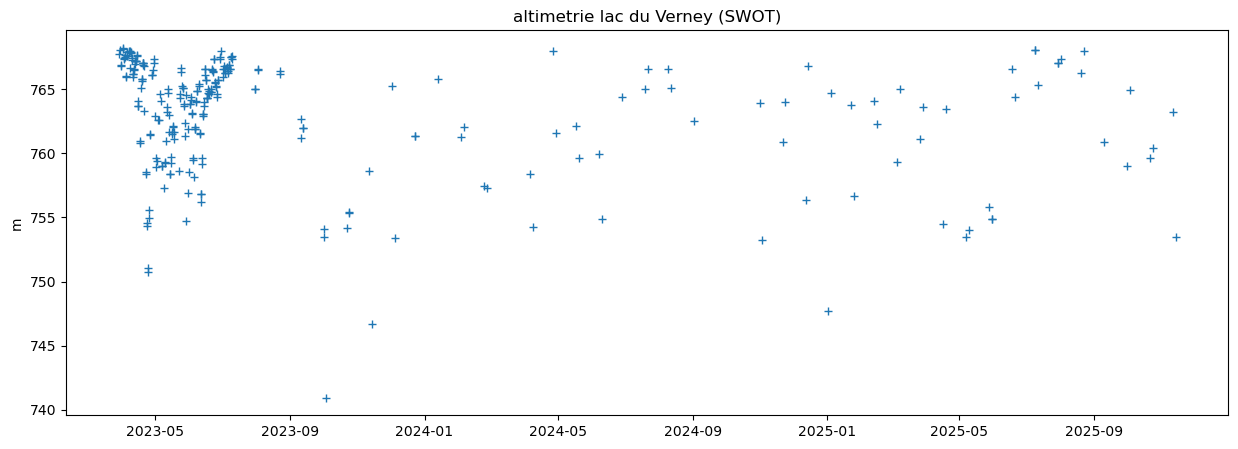

In [58]:
plt.figure(figsize = (15, 5))
plt.plot(date, level, '+')
plt.title("altimetrie lac du Verney (SWOT)")
plt.ylabel("m")

In [59]:
df_level = pd.DataFrame(np.array([date, level]).T, columns=('date', 'level'))
df_var = pd.DataFrame(np.array([do_command_oz.index, volume_oz[1:]]).T, columns= ('date', 'var'))
df_level = df_level.dropna()

In [60]:
df_level["date"] = df_level["date"].dt.tz_localize('UTC')
df_level = df_level.sort_values(by = ["date"])
df_level = df_level.reset_index(drop=True)

Text(0.5, 1.0, 'oz')

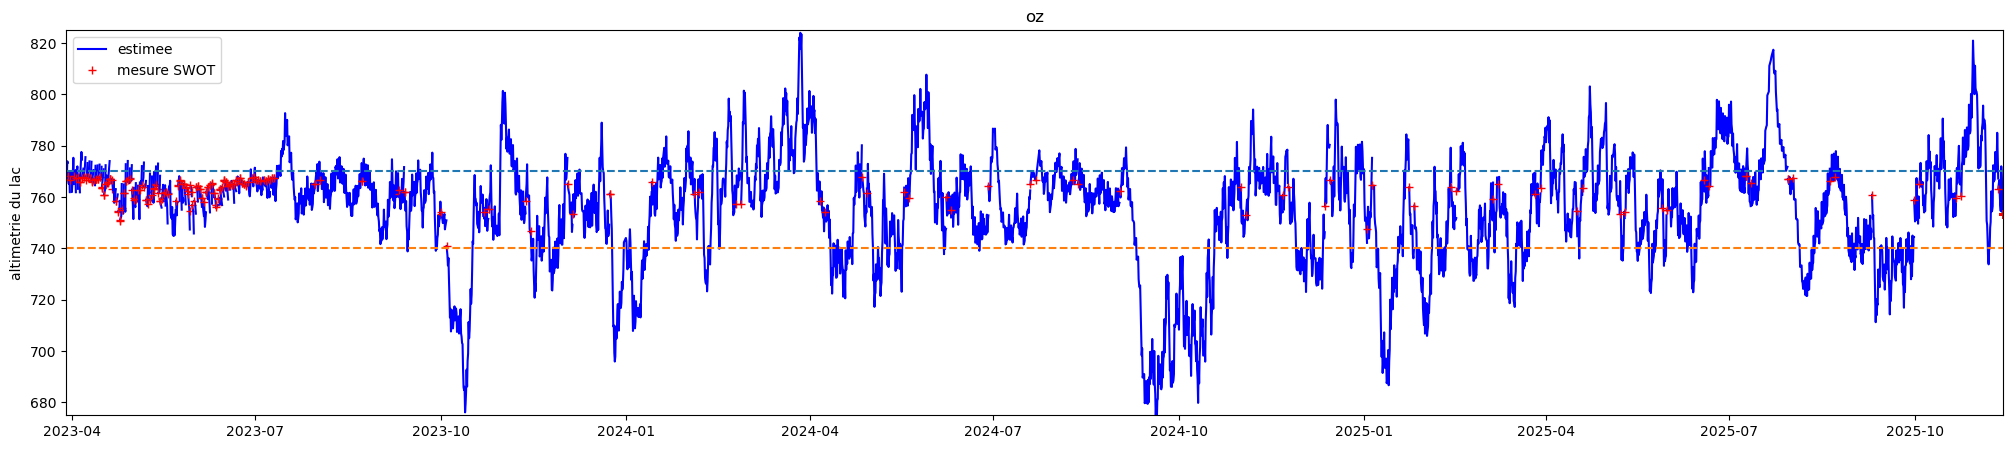

In [61]:
i = 0

l = []
t = []
corr = 0
corr_list_oz = []
t_corr_oz = []
plt.figure(figsize=(25, 5))

for d, var in zip(df_var['date'], df_var['var']) :
    if d < df_level['date'][i] :
        l.append(var/14e6*70 + corr)
        t.append(d)
    else :
        plt.plot(t, l - (corr - df_level["level"][i] + var/14e6*70) * np.arange(0, len(t), 1)/len(t), 'b')
        plt.plot(t[0], l[0], 'r+')
        t_corr_oz.append(df_level["date"][i])
        corr_list_oz.append(corr - df_level["level"][i] + var/14e6*70)
        
        l = [df_level["level"][i]]
        t = [df_level["date"][i]]
        corr = df_level["level"][i] - var/14e6*70
        if i + 1 < len(df_level["date"]):
            i += 1

plt.plot([df_level["date"][0], list(df_level["date"])[-1]], [770, 770], '--')  
plt.plot([df_level["date"][0], list(df_level["date"])[-1]], [740, 740], '--')       
plt.xlim(df_level["date"][0], list(df_level["date"])[-1])
plt.ylim(675, 825)
plt.ylabel("altimetrie du lac")
plt.legend(["estimee", "mesure SWOT"])
plt.title("oz")

Text(0.5, 1.0, 'corrections altimétriques appliquées sur les différents lacs de la step')

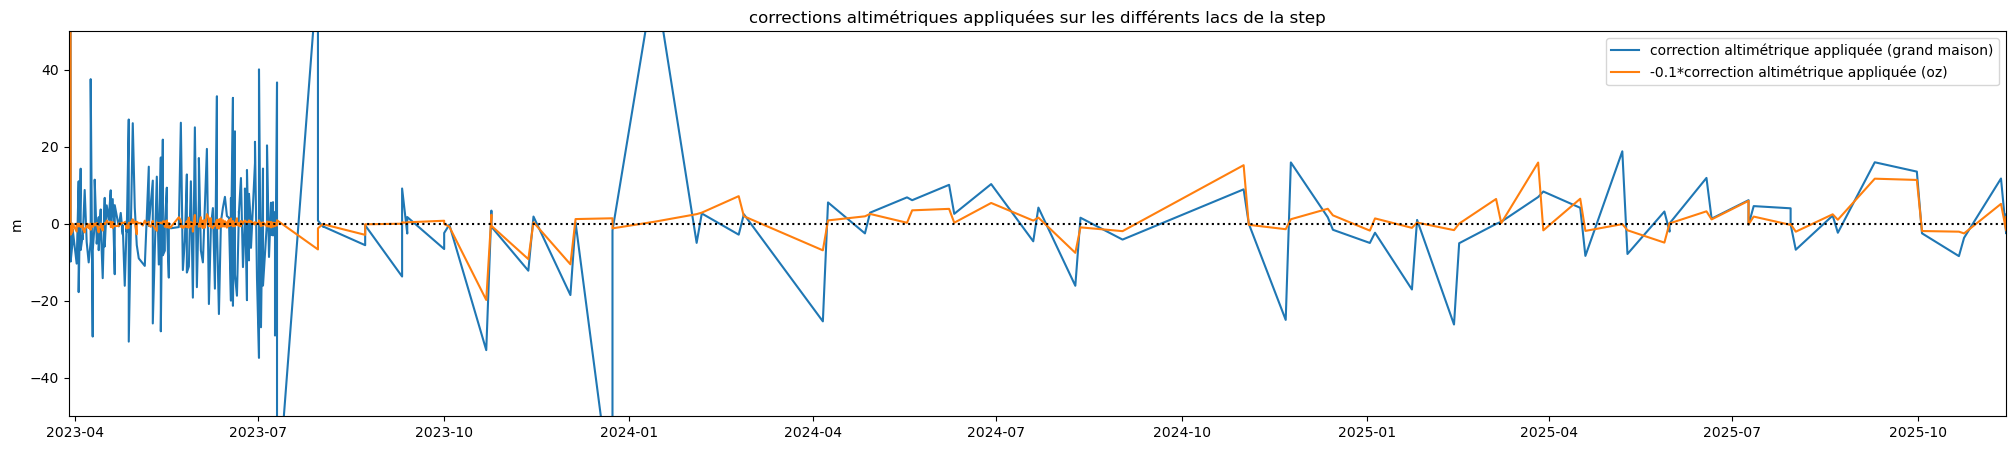

In [62]:
plt.figure(figsize = (25, 5))
plt.plot(t_corr_gm, -np.array(corr_list_gm))
plt.plot(t_corr_oz, np.array(corr_list_oz)/10)
plt.plot([t_corr_oz[0], t_corr_oz[-1]], [0, 0], 'k:')
plt.ylim(-50, 50)
plt.xlim(t_corr_oz[0], t_corr_oz[-1])
plt.ylabel("m")
plt.legend(["correction altimétrique appliquée (grand maison)", "-0.1*correction altimétrique appliquée (oz)"])
plt.title("corrections altimétriques appliquées sur les différents lacs de la step")

Text(0, 0.5, 'volume')

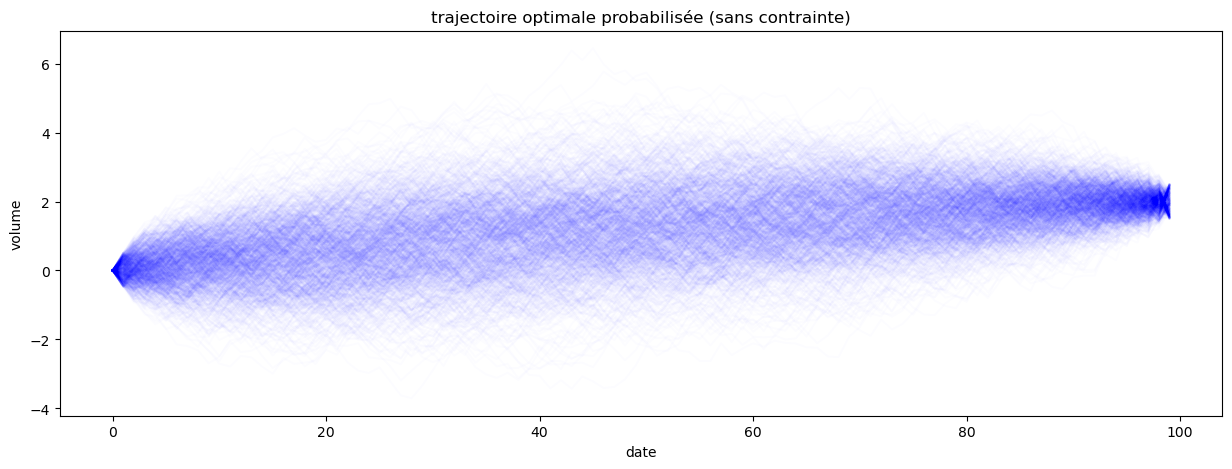

In [63]:
plt.figure(figsize=(15, 5))


time = np.arange(0, 100, 1)
target = 2
for i in range(1000) :
    traj = [0]
    for t in time[:-1] :
        meanTraj = (target - traj[-1])/(time[-1] - t)
        if meanTraj >= 0.5 :
            traj.append(traj[-1] + 0.5)
        elif meanTraj <= -0.5 :
            traj.append(traj[-1] - 0.5)
        else :
            ind = np.random.random() - 0.5
            traj.append(traj[-1] + 2*meanTraj + 2*max(0, ind)*(0.5 - meanTraj) + 2*min(0, ind)*(meanTraj + 0.5))
    plt.plot(time, traj, alpha = 0.01, color = "blue")
plt.title("trajectoire optimale probabilisée (sans contrainte)")
plt.xlabel("date")
plt.ylabel("volume")


Text(0.5, 1.0, 'variation aditionnelle')

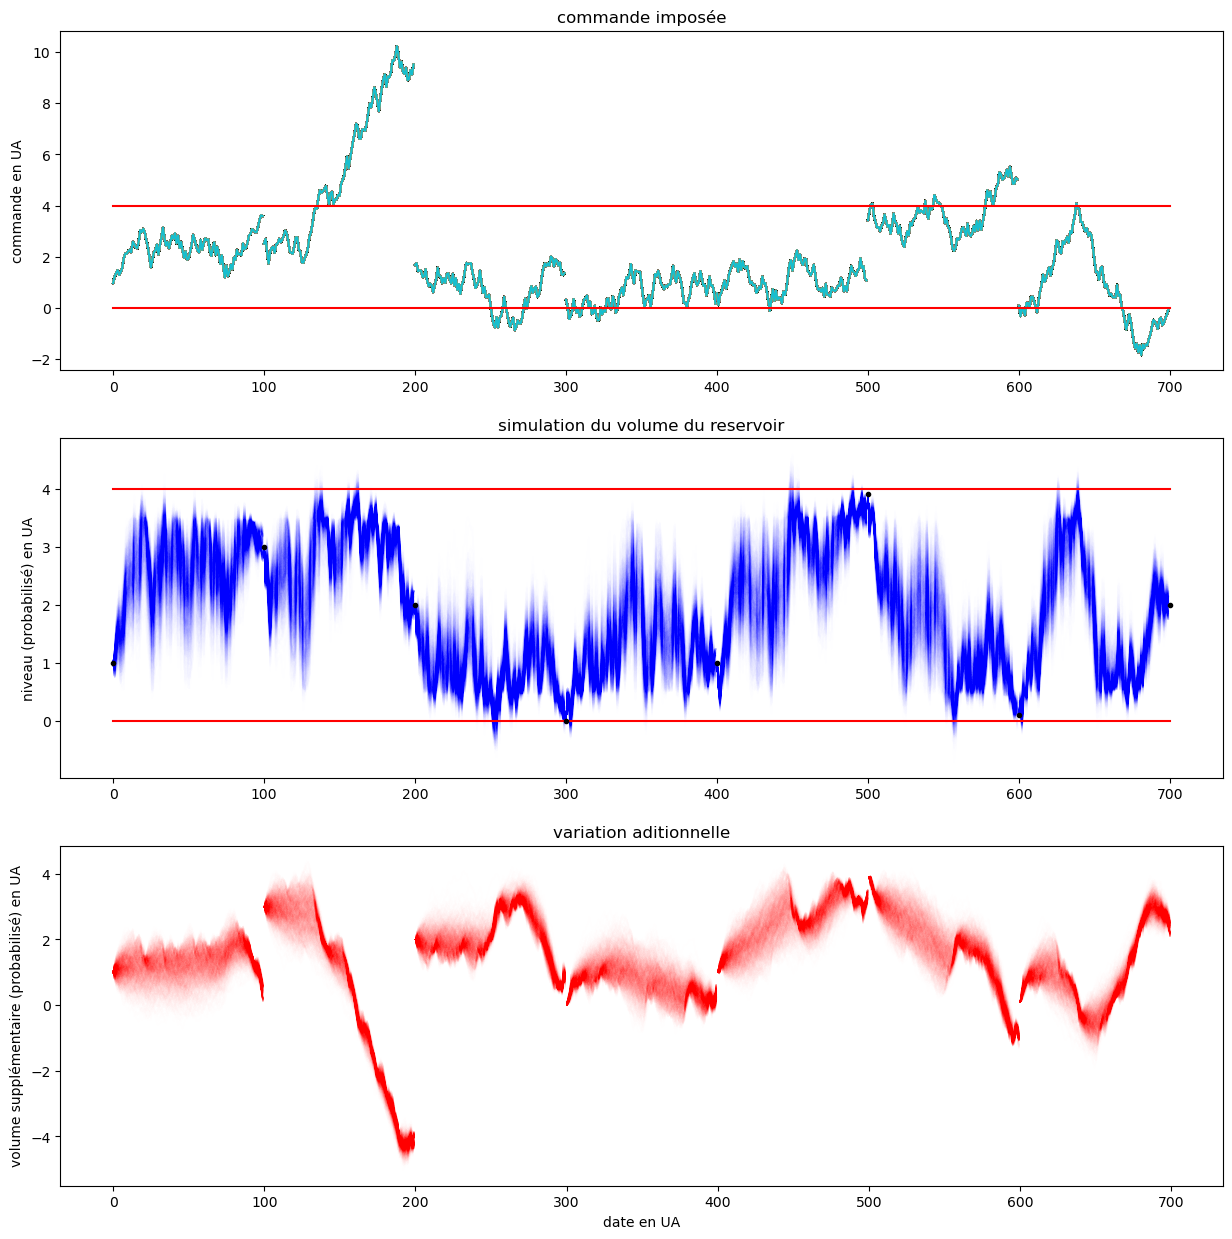

In [64]:
steps = [1, 3, 2, 0.01, 1, 3.9, 0.1, 2]
initTime = 0
traj = []
varReservoirPos = 0.25
varReservoirNeg = 0.25

fig, ax = plt.subplots(3, 1, figsize = (15, 15))
for i in range(len(steps[1:])) :
    
    target = steps[i + 1]
    time = np.arange(initTime, initTime + 100, 1)
    command = np.random.random(100) - 0.5
    initTime += 100
    for j in range(1000) :
        traj = [steps[i]]
        spill = [steps[i]]
        k = 0
        for t in time[:-1] :
            meanTraj = (target - traj[-1]- command[k])/(time[-1] - t)
            maxTraj = min(varReservoirPos, 3.5 - traj[-1] - command[k])
            minTraj = max(-varReservoirNeg, 0.5 - traj[-1] - command[k])
            if meanTraj >= varReservoirPos :
                traj.append(traj[-1] + varReservoirPos + command[k])
                spill.append(spill[-1] + varReservoirPos)
            elif meanTraj <= -varReservoirNeg :
                traj.append(traj[-1] - varReservoirNeg + command[k])
                spill.append(spill[-1] - varReservoirNeg)
            else :
                ind = np.random.random() - varReservoirPos/(varReservoirNeg + varReservoirPos)
                traj.append(traj[-1] + 2*meanTraj + 2*max(0, ind)*(maxTraj - meanTraj) + 2*min(0, ind)*(meanTraj -minTraj) + command[k])
                spill.append(spill[-1] + 2*meanTraj + 2*max(0, ind)*(maxTraj - meanTraj) + 2*min(0, ind)*(meanTraj -minTraj))
            k+=1
        ax[0].plot(time, traj[0] + np.cumsum(command))
        ax[1].plot(time, traj, alpha = 0.005, color = "blue")
        ax[2].plot(time, spill, alpha = 0.005, color = "red")
        


ax[0].set_ylabel("commande en UA")
ax[0].set_title("commande imposée")
ax[0].plot([0, 700], [0, 0], 'r-')
ax[0].plot([0, 700], [4, 4], 'r-')
ax[1].set_ylabel("niveau (probabilisé) en UA")
ax[1].set_title("simulation du volume du reservoir")
ax[1].plot([0, 700], [0, 0], 'r-')
ax[1].plot([0, 700], [4, 4], 'r-')
ax[1].plot([0, 100, 200, 300, 400, 500, 600, 700], steps, 'k.')
ax[2].set_xlabel("date en UA")
ax[2].set_ylabel("volume supplémentaire (probabilisé) en UA")
ax[2].set_title("variation aditionnelle")

In [65]:
##test de reconstruction sur le lac du Sautet (présenc d'une mesure EDF)
listFiles = os.listdir("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m/")
filtered = gdf[gdf["DAM_NAME"] == "Le Sautet"] #même processus pour le lac du sautet

upperLeft = (44.769371595340495, 5.9) 
lowerRight = (44.82612949721342, 6)

In [66]:
#permet de recuperer les coordonnées du lac du Sautet pour les 2 phases orbiatales, pour ensuite calculer la hauteur du lac

for file in listFiles :
    if '.nc' == file[-3:] :
        if file.split('_')[5] == 'UTM31T':
            (xmin, ymin) = transformer31.transform(upperLeft[0], upperLeft[1])
            (xmax, ymax) = transformer31.transform(lowerRight[0], lowerRight[1])
            temp = xr.open_dataset("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m/" + file)
            tempReduced = temp["wse"].where((temp.x > xmin) & (temp.x < xmax) & (temp.y > ymin) & (temp.y < ymax), drop = True)
            X, Y = np.meshgrid(tempReduced.x.values, tempReduced.y.values)
            pts = [Point(x, y) for x, y in zip(X.flatten(), Y.flatten())]
            polygon = filtered.to_crs(epsg=32631).iloc[0].geometry
            mask = [polygon.contains(pt) for pt in pts]
            
            X_in_31 = X.flatten()[mask]
            Y_in_31 = Y.flatten()[mask]
            break 

for file in listFiles :
    if '.nc' == file[-3:] :
        if file.split('_')[5] == 'UTM32T':
            (xmin, ymin) = transformer32.transform(upperLeft[0], upperLeft[1])
            (xmax, ymax) = transformer32.transform(lowerRight[0], lowerRight[1])
            temp = xr.open_dataset("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m/" + file)
            tempReduced = temp["wse"].where((temp.x > xmin) & (temp.x < xmax) & (temp.y > ymin) & (temp.y < ymax), drop = True)
            X, Y = np.meshgrid(tempReduced.x.values, tempReduced.y.values)
            pts = [Point(x, y) for x, y in zip(X.flatten(), Y.flatten())]
            polygon = filtered.to_crs(epsg=32632).iloc[0].geometry
            mask = [polygon.contains(pt) for pt in pts]
            
            X_in_32 = X.flatten()[mask]
            Y_in_32 = Y.flatten()[mask]
            break 

In [67]:
dateS = [] #permet de recalculer les altimetrie du lac
levelS = []
uncertS = []
for file in tqdm(listFiles) :
    if ('.nc' == file[-3:]):
        if file.split('_')[5] == 'UTM31T':
            X_lake = X_in_31
            Y_lake = Y_in_31
        else :
            X_lake = X_in_32
            Y_lake = Y_in_32

        temp = xr.open_dataset("C:/Users/paoliniart/Documents/SWOT_Level_2_HR_Raster_100m/" + file)
        dateS.append(datetime.datetime.strptime(file.split("_")[14], "%Y%m%dT%H%M%S"))
        wseList = []
        uncertList = []
        for x_i, y_i in zip(X_lake, Y_lake) :
            wseList.append(temp.sel(x = x_i, y = y_i).wse.values)
            uncertList.append(temp.sel(x = x_i, y = y_i).wse_uncert.values)
            if (wseList[-1] > 765) | (wseList[-1] < 725) :
                wseList = wseList[:-1]
                uncertList = uncertList[:-1]
        levelS.append(np.nanmean(np.array(wseList)))
        uncertS.append(np.nanmean(np.array(uncertList)))

 51%|█████▏    | 1633/3184 [02:46<02:40,  9.67it/s]C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1616563889.py:23: RuntimeWarning: Mean of empty slice
  levelS.append(np.nanmean(np.array(wseList)))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1616563889.py:24: RuntimeWarning: Mean of empty slice
  uncertS.append(np.nanmean(np.array(uncertList)))
 52%|█████▏    | 1645/3184 [02:47<02:39,  9.65it/s]C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1616563889.py:23: RuntimeWarning: Mean of empty slice
  levelS.append(np.nanmean(np.array(wseList)))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\1616563889.py:24: RuntimeWarning: Mean of empty slice
  uncertS.append(np.nanmean(np.array(uncertList)))
100%|██████████| 3184/3184 [05:26<00:00,  9.74it/s]


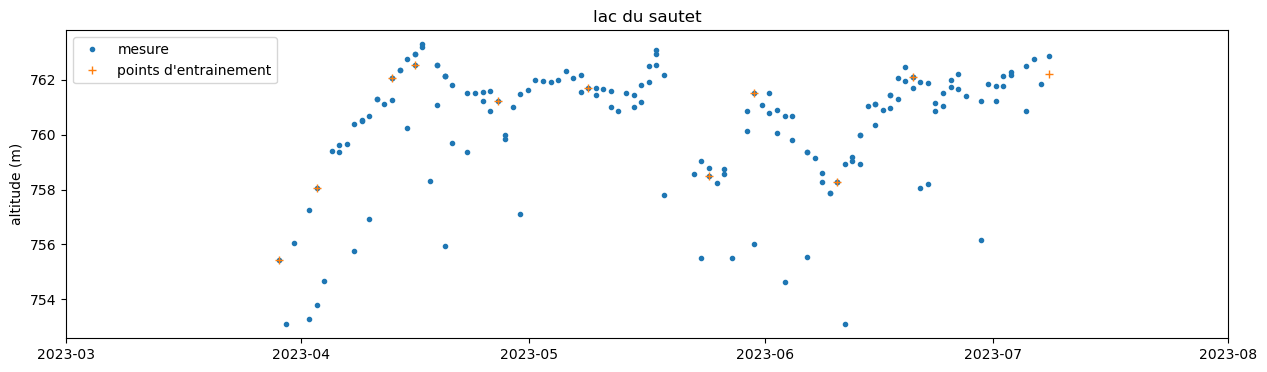

In [68]:
plt.figure(figsize = (15, 4))
plt.plot(dateS[93:260], levelS[93:260], '.')
plt.xlim(datetime.datetime(2023, 3, 1), datetime.datetime(2023, 8, 1))
plt.plot(np.array(dateS)[[93,98, 115, 123, 145, 160, 183, 190, 210, 230, 260]], np.array(levelS)[[93,98, 115, 123, 145, 160, 183, 190, 210, 230, 260]], '+')
plt.title("lac du sautet")
plt.ylabel("altitude (m)")
plt.legend(["mesure", "points d'entrainement"])

In [69]:
command_sautet = prodCentrales["SAUTEH"].resample('1d').mean()
apport_sautet = pd.read_csv("C:/Users/paoliniart/Documents/Arthur_thèse hydro/tests/debits/apport_sautet_2023.csv")[["Date (TU)", "Valeur (en m³/s)"]]

In [70]:
command_sautet = command_sautet[(command_sautet.index > pd.to_datetime(apport_sautet["Date (TU)"])[0]) & (command_sautet.index < pd.to_datetime(apport_sautet["Date (TU)"])[364])]

Text(0, 0.5, 'impact sur la hauteur (en m)')

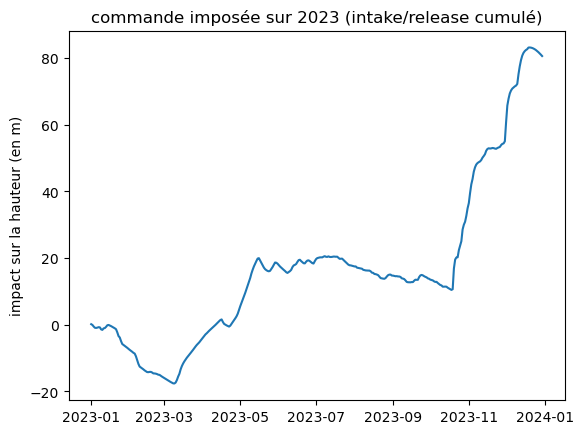

In [71]:
plt.plot(pd.to_datetime(apport_sautet["Date (TU)"])[:-1], (np.cumsum(apport_sautet["Valeur (en m³/s)"][:-1]) - np.cumsum(command_sautet.values)/76.5*102)*(24*3600)/3500000)
plt.title("commande imposée sur 2023 (intake/release cumulé)")
plt.ylabel("impact sur la hauteur (en m)")

In [72]:
command = pd.Series(data = ((apport_sautet["Valeur (en m³/s)"][:-1] - command_sautet.values/76.5*102)*(24*3600)/3500000).values, index = pd.to_datetime(apport_sautet["Date (TU)"])[:-1])

In [73]:
dateS = pd.to_datetime(pd.Series(dateS)).dt.round('D')

C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\3289345255.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meanTrajInstant = (target - traj[-1]- cm[k])/((time[-1] - t)/(np.timedelta64(1, 'D') - 1))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\3289345255.py:24: RuntimeWarning: divide by zero encountered in divide
  meanTrajInstant = (target - traj[-1]- cm[k])/((time[-1] - t)/(np.timedelta64(1, 'D') - 1))
C:\Users\paoliniart\AppData\Local\Temp\ipykernel_11260\3289345255.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  maxTraj = min(varReservoirPos, 765 - traj[-1] - cm[k])
C:\Users\paoliniart\A

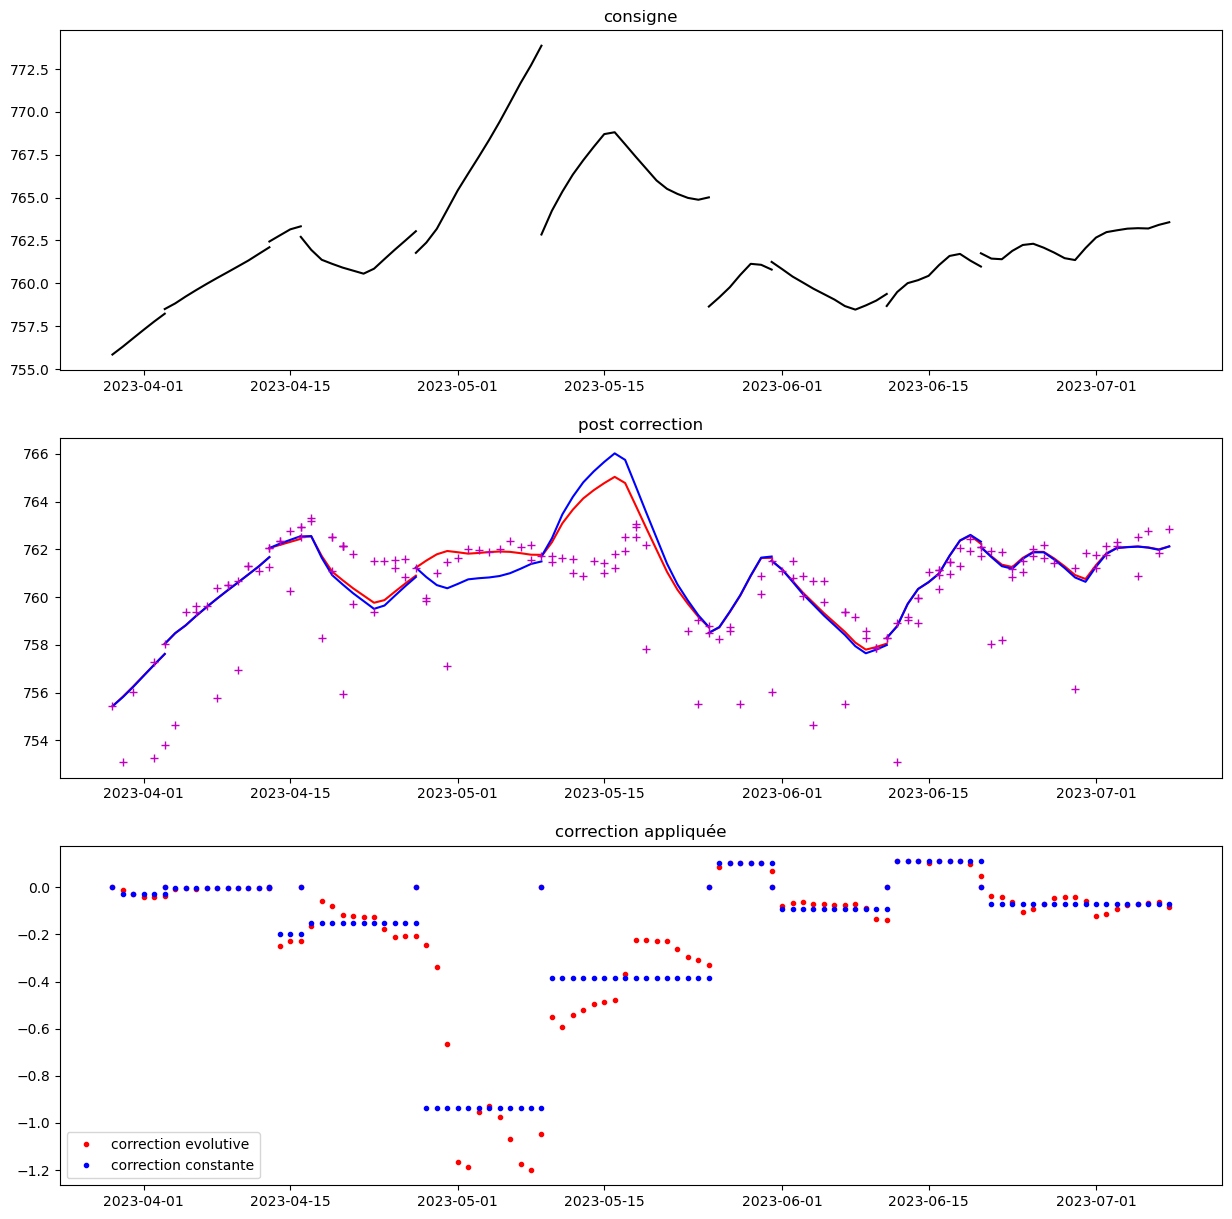

In [103]:
steps = np.array(levelS)[[93,98, 115, 123, 145, 160, 183, 190, 210, 230, 260]]
timeStep = np.array(dateS)[[93,98, 115, 123, 145, 160, 183, 190, 210, 230, 260]]
traj = []
varReservoirPos = 1
varReservoirNeg = 1
derive = np.array([0] + list(np.cumsum(command.values[1:]) - np.cumsum(command.values[:-1])))

fig, ax = plt.subplots(3, 1, figsize = (15, 15))
for i in range(len(steps[1:])) :
    target = steps[i + 1]
    time = np.arange(timeStep[i], timeStep[i + 1] + np.timedelta64(1, 'D'), datetime.timedelta(1))
    tstart = pd.Timestamp(timeStep[i]).tz_localize('UTC')  
    tend = pd.Timestamp(timeStep[i+1]).tz_localize('UTC')
    cm = command[(command.index >= tstart) & (command.index <= tend)]
    dr = derive[(command.index >= tstart) & (command.index <= tend)]
    dr = (np.array([1] * len(dr)) + (dr - np.mean(dr))/(3 *np.std(dr)))
    
    meanTraj = (steps[i] + np.sum(cm) - target)/((tstart - tend).days - 1)
    for j in range(1) :
        traj = [steps[i]]
        spill = [0]
        k = 0
        for t in time[:-1] :
            meanTrajInstant = (target - traj[-1]- cm[k])/((time[-1] - t)/(np.timedelta64(1, 'D') - 1))
            maxTraj = min(varReservoirPos, 765 - traj[-1] - cm[k])
            minTraj = max(-varReservoirNeg, 725 - traj[-1] - cm[k])
            if meanTrajInstant >= varReservoirPos :
                traj.append(traj[-1] + varReservoirPos + cm[k])
                spill.append(spill[-1] + varReservoirPos)
            elif meanTrajInstant <= -varReservoirNeg :
                traj.append(traj[-1] - varReservoirNeg + cm[k])
                spill.append(spill[-1] - varReservoirNeg)
            else :
                ind = 0
                traj.append(traj[-1] + min(max(0, meanTraj), meanTraj*dr[k]) + cm[k])
                spill.append(min(max(0, meanTraj), meanTraj*dr[k]))
            k+=1
        ax[0].plot(time, traj[0] + np.cumsum(cm), color = "black")
        ax[1].plot(time, traj, alpha = 1, color = "red")
        ax[2].plot(time, spill, '.', alpha = 1, color = "red")

        traj = [steps[i]]
        spill = [0]
        k = 0
        for t in time[:-1] :
            meanTrajInstant = (target - traj[-1]- cm[k])/((time[-1] - t)/(np.timedelta64(1, 'D') - 1))
            maxTraj = min(varReservoirPos, 765 - traj[-1] - cm[k])
            minTraj = max(-varReservoirNeg, 725 - traj[-1] - cm[k])
            if meanTrajInstant >= varReservoirPos :
                traj.append(traj[-1] + varReservoirPos + cm[k])
                spill.append(spill[-1] + varReservoirPos)
            elif meanTrajInstant <= -varReservoirNeg :
                traj.append(traj[-1] - varReservoirNeg + cm[k])
                spill.append(spill[-1] - varReservoirNeg)
            else :
                ind = 0
                traj.append(traj[-1] + meanTraj + cm[k])
                spill.append(meanTraj)
            k+=1
        ax[1].plot(time, traj, alpha = 1, color = "blue")
        ax[2].plot(time, spill, '.', alpha = 1, color = "blue")

ax[1].plot(dateS[93:260], levelS[93:260], '+m')

ax[0].set_title("consigne")
ax[1].set_title("post correction")
ax[2].set_title("correction appliquée")
ax[2].legend(["correction evolutive", "correction constante"])

In [104]:
def findTrajectories(v_up, v_down, apports, alpha, consigne_t_up, consigne_t_down, consigne_pump, mesures_up, mesures_down, varmax, iter = 400, show = False) :
    v_min_up = v_up[0]
    v_max_up = v_up[1]
    v_min_down = v_down[0]
    v_max_down = v_down[1]
    time = np.arange(0, 20, 1)
    metrics = 0
    additional = []
    if show :
        fig, ax = plt.subplots(6, 1, figsize = (10, 20))
    for i in range(iter) :
        traj_up = [mesures_up[0]]
        traj_down = [mesures_down[0]]
        traj_spill_interne = [0]
        traj_spill_externe = [0]
        traj_additional = [0]
        for t,ct_u, ct_d, cp, a in zip(time[: -1], consigne_t_up[: -1], consigne_t_down[:-1], consigne_pump[:-1], apports) :
            meanTraj_up = (mesures_up[1] - traj_up[-1])/(time[-1] - t)
            meanTraj_down = (mesures_down[1] - traj_down[-1])/(time[-1] - t)
            addforced_up = 0
            addforced_down = 0
            if meanTraj_up >= varmax :
                traj_spill_interne.append(0)
                addforced_up = varmax

            elif meanTraj_up <= -varmax :
                traj_spill_interne.append(-varmax)

            else : 
                ind = np.random.normal(meanTraj_up, (meanTraj_up+varmax)/3)
                up_spill = min(0, ind)
                if traj_up[-1]  - ct_u + cp + up_spill >= v_max_up :
                    up_spill = up_spill - (traj_up[-1]  - ct_u + cp + up_spill - v_max_up)
                elif traj_up[-1]  - ct_u + cp + up_spill <= v_min_up :
                    up_spill = up_spill - (traj_up[-1]  - ct_u + cp + up_spill - v_min_up)
                traj_spill_interne.append(min(0, up_spill))
            traj_up.append(traj_up[-1]  - ct_u + cp + traj_spill_interne[-1] + alpha*a + max(0, up_spill) + addforced_up/alpha)
            traj_additional.append(max(0, up_spill)+ addforced_up/alpha)

            if meanTraj_down >= varmax :
                traj_spill_externe.append(0)
                addforced_down = varmax

            elif meanTraj_down <= -varmax :
                traj_spill_externe.append(-varmax)
            
            else :
                ind = np.random.normal(meanTraj_down, (meanTraj_down+varmax)/3)
                down_spill = min(0, ind)
                if traj_down[-1]  + ct_u - cp -ct_d - up_spill + down_spill >= v_max_down :
                    down_spill = down_spill - (traj_down[-1]  + ct_u - cp -ct_d - up_spill + down_spill - v_max_down)
                elif traj_down[-1]  + ct_u - cp -ct_d - up_spill + down_spill <= v_min_down :
                    down_spill = down_spill - (traj_down[-1]  + ct_u - cp -ct_d - up_spill + down_spill - v_min_up)
                traj_spill_externe.append(min(0, down_spill))
            traj_down.append(traj_down[-1]  + ct_u - cp -ct_d - up_spill + down_spill - traj_spill_interne[-1] + traj_spill_externe[-1] + (1 - alpha)*a + max(0, down_spill) + addforced_down/(1 - alpha))
            traj_additional[-1] += max(0, up_spill)+ addforced_down
            traj_spill_interne[-1] += -alpha*addforced_down    
        if show : 
            ax[0].plot(time, traj_up, 'b', alpha = 0.01)
            ax[1].plot(time, traj_down, 'b', alpha = 0.01)
            ax[5].plot(time, np.cumsum(apports + traj_additional), 'r', alpha = 0.01)
            ax[3].plot(time, np.cumsum(traj_spill_interne), 'g', alpha = 0.01)
            ax[4].plot(time, np.cumsum(traj_spill_externe), 'g', alpha = 0.01)
            ax[2].plot(time, np.cumsum(traj_spill_externe - consigne_t_down), 'g', alpha = 0.01)
            ax[0].set_title("variation volume (up)")
            ax[1].set_title("variation volume (down)")
            ax[5].set_title("apports")
            ax[3].set_title("spillage (interne)")
            ax[4].set_title("spillage (externe)")
            ax[2].set_title("evacué step")
        
        if additional == [] :
            additional = traj_additional
            metrics = (sum(traj_spill_externe)**2 + sum(traj_spill_interne)**2 + sum(apports + traj_additional)**2)**0.5
        
        else :
            if (sum(traj_spill_externe)**2 + sum(traj_spill_interne)**2 + sum(apports + traj_additional)**2)**0.5 < metrics :
                additional = traj_additional
                metrics = (sum(traj_spill_externe)**2 + sum(traj_spill_interne)**2 + sum(apports + traj_additional)**2)**0.5
    return (additional, metrics)









    

In [105]:
def findTrajectories_single(v_up, v_down, apports, alpha, consigne_t_up, consigne_t_down, consigne_pump, mesures_up, mesures_down, varmax) :
    v_min_up = v_up[0]
    v_max_up = v_up[1]
    v_min_down = v_down[0]
    v_max_down = v_down[1]
    time = np.arange(0, 20, 1)
    traj_up = [mesures_up[0]]
    traj_down = [mesures_down[0]]
    traj_spill_interne = [0]
    traj_spill_externe = [0]
    traj_additional = [0]
    for t,ct_u, ct_d, cp, a in zip(time[: -1], consigne_t_up[: -1], consigne_t_down[:-1], consigne_pump[:-1], apports) :
        meanTraj_up = (mesures_up[1] - traj_up[-1])/(time[-1] - t)
        meanTraj_down = (mesures_down[1] - traj_down[-1])/(time[-1] - t)
        addForced_up = 0
        addForced_down = 0
        upSpill = 0
        lowSpill = 0
        if meanTraj_up >= varmax :
            addForced_up += varmax
            addForced_down += varmax/alpha*(1-alpha)

        elif meanTraj_up <= -varmax :
            upSpill += varmax

        else : 
            upTraj = scipy.stats.triang(varmax + meanTraj_up, loc = -varmax, scale = 2*varmax).rvs()
            upTrajWithoutSpill = traj_up[-1] - ct_u + cp + alpha*a

            if upTrajWithoutSpill < v_min_up :
                addForced_up += varmax
                addForced_down += varmax/alpha*(1-alpha)

            elif upTrajWithoutSpill > v_max_up :
                upSpill += varmax
            
            else :
                upSpill += -min(0, upTraj)


        if meanTraj_down >= varmax :
            addForced_down += varmax*(1-alpha)
            addForced_up += alpha*varmax
            upSpill += alpha*varmax  
        
        elif meanTraj_down <= -varmax :
            lowSpill += 2*varmax

        else :
            downTraj = scipy.stats.triang(varmax + meanTraj_down, loc = -varmax, scale = 2*varmax).rvs()
            downTrajWithoutSpill = traj_down[-1] + ct_u - cp - ct_d + upSpill + (1-alpha)*a + addForced_down

            if downTrajWithoutSpill < v_min_down :
                addForced_down += varmax*(1-alpha)
                addForced_up += alpha*varmax
                upSpill += alpha*varmax

            elif downTrajWithoutSpill > v_max_down :
                lowSpill += 2*varmax

            else :
                lowSpill += -min(0, downTraj)

        traj_up.append(traj_up[-1] - ct_u + cp + alpha*a -upSpill + addForced_up)
        traj_down.append(traj_down[-1] + ct_d - cp - ct_d + (1 - alpha)*a + upSpill - lowSpill + addForced_down)
        traj_spill_interne.append(upSpill)
        traj_spill_externe.append(lowSpill)
        traj_additional.append(addForced_down + addForced_up)
    

    metrics = (sum(traj_spill_externe)**2 + sum(traj_spill_interne)**2 + sum(apports + traj_additional)**2)**0.5
    
    return (metrics, traj_additional, traj_up, traj_down, traj_spill_interne, traj_spill_externe)

In [106]:
def findTrajectories_parallel(v_up, v_down, apports, alpha, consigne_t_up, consigne_t_down, consigne_pump, mesures_up, mesures_down, varmax, iter = 800, show = False, n_jobs = -1) :
    results = Parallel(n_jobs=n_jobs)(
        delayed(findTrajectories_single)(
            v_up, v_down, apports, alpha, consigne_t_up, consigne_t_down, consigne_pump, mesures_up, mesures_down, varmax
        ) for seed in range(iter)
    )
    # results est une liste de tuples (traj_additional, metrics)
    best_index = np.argmin([metrics for (metrics, _, _, _, _, _) in results])
    best_additional = results[best_index][1]
    best_metrics = results[best_index][0]
    # Optionnel : affichage (trace UN seul exemple parmi les runs optimum)
    if show:
        time = np.arange(0, 20, 1)
        fig, ax = plt.subplots(6, 1, figsize = (10, 20))
        ax[0].set_title("variation volume (up)")
        ax[1].set_title("variation volume (down)")
        ax[5].set_title("apports")
        ax[3].set_title("spillage (interne)")
        ax[4].set_title("spillage (externe)")
        ax[2].set_title("evacué step")
        for r in results :
            ax[0].plot(time, r[2], 'b', alpha = 0.01)
            ax[1].plot(time, r[3], 'b', alpha = 0.01)
            ax[5].plot(time, np.cumsum(apports + r[1]), 'r', alpha = 0.01)
            ax[3].plot(time, np.cumsum(r[4]), 'g', alpha = 0.01)
            ax[4].plot(time, np.cumsum(r[-1]), 'g', alpha = 0.01)
            ax[2].plot(time, np.cumsum(r[-1] + consigne_t_down), 'g', alpha = 0.01)


    return best_metrics, apports + best_additional 

In [107]:
def evol(traj, var, childrens = 100, meanVar = -0.1) :
    newGen = []
    for i in range(childrens) :
        index_to_shuffle = np.random.choice(len(traj), int(0.03*len(traj)), replace = False)
        shuffle_values = traj[index_to_shuffle].copy()
        np.random.shuffle(shuffle_values)
        newTraj = traj.copy()
        newTraj[index_to_shuffle] = shuffle_values
        geneticVar = np.random.normal(meanVar, var, len(traj))
        newGen.append(np.maximum(newTraj + geneticVar, np.zeros(len(newTraj))))

    return newGen


In [108]:
def cross(trajs, ratio = 0.5) :
    return 

In [109]:
upper_storage = [1, 10]
lower_storage = [1, 2]
alpha = 0.4
consigne_t_up = np.random.random(20)*0.3
consigne_t_down = np.random.random(20)*0.1
consigne_p = np.random.random(20)*0.3
upper_var = [2, 2.5]
lower_var = [1.5, 1.2]
maxvar = 0.2
app = np.zeros(20)


Text(0.5, 1.0, 'apports cumulés initiaux')

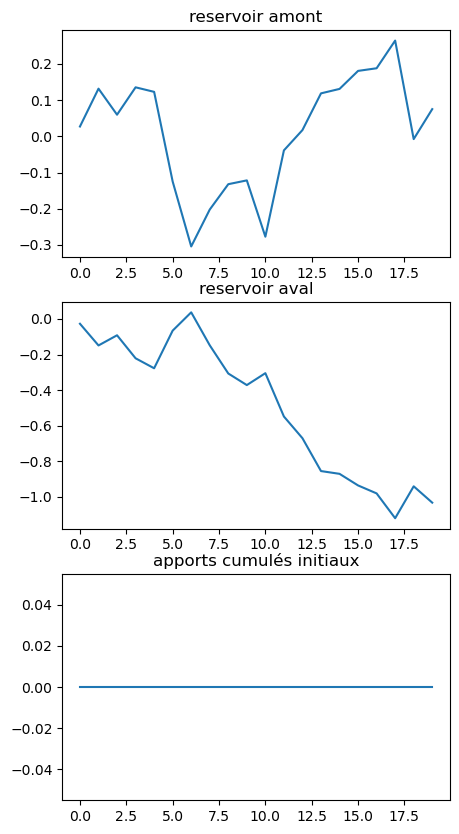

In [110]:
fig, ax = plt.subplots(3, 1, figsize = (5, 10))
ax[0].plot(np.arange(0, 20, 1), np.cumsum(consigne_p - consigne_t_up))
ax[1].plot(np.arange(0, 20, 1), np.cumsum(-consigne_p + consigne_t_up - consigne_t_down))
ax[2].plot(np.arange(0, 20, 1), np.cumsum(app))
ax[0].set_title("reservoir amont")
ax[1].set_title("reservoir aval")
ax[2].set_title("apports cumulés initiaux")

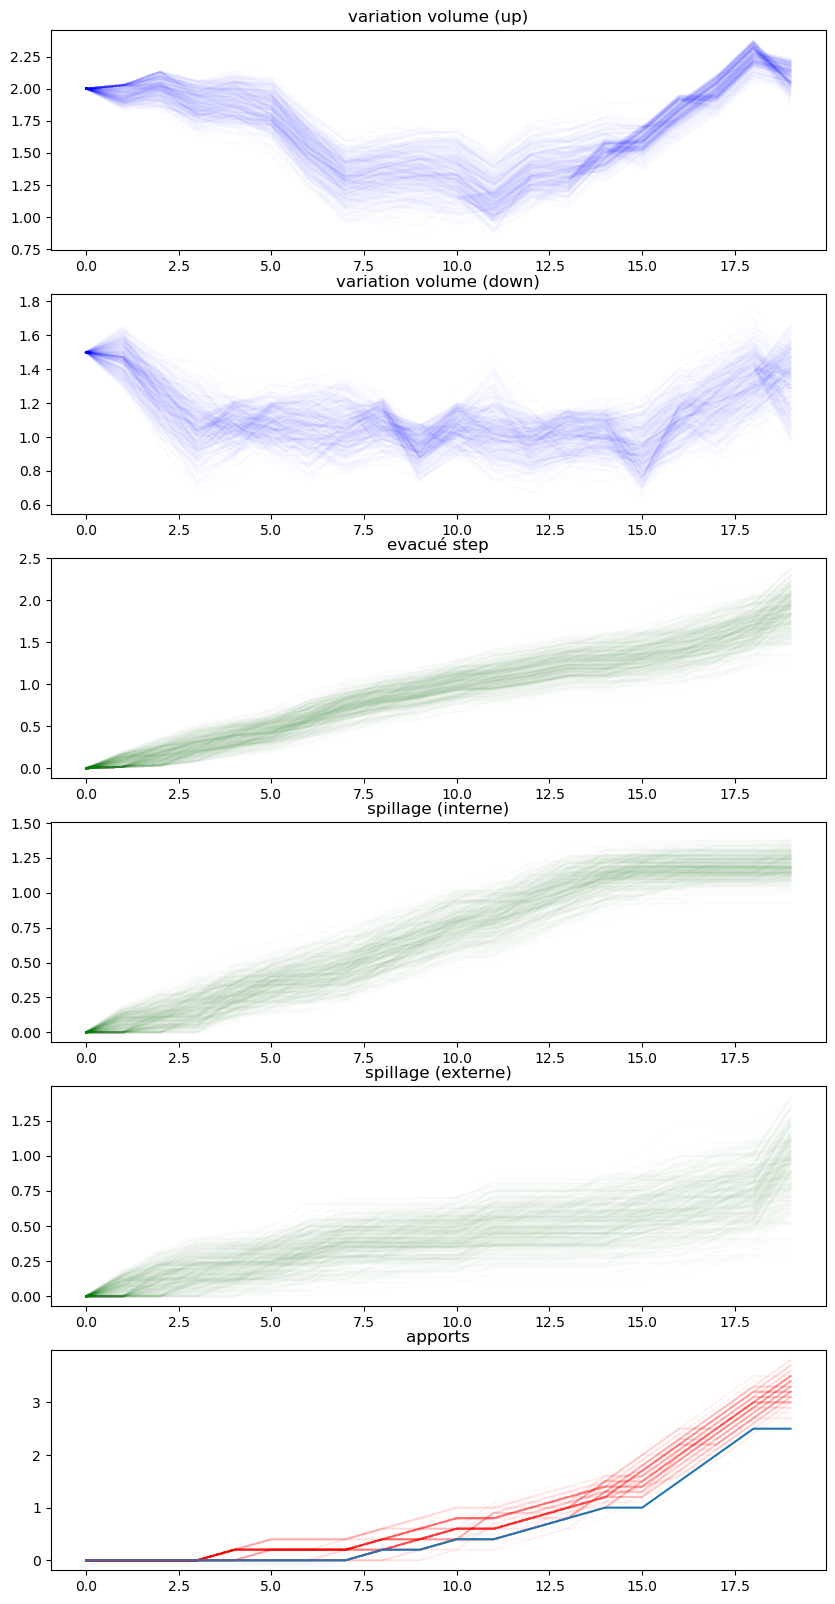

In [111]:
(m_0, t_0) = findTrajectories_parallel(
    upper_storage, lower_storage, app, alpha, consigne_t_up, consigne_t_down, consigne_p, upper_var, lower_var, maxvar,
    iter=300, show=True, n_jobs= -1
)
plt.plot(np.arange(0, 20, 1), np.cumsum(t_0))

In [112]:
new_traj = evol(t_0, 0.2)
m_evol = [m_0]
for i in tqdm(range(50)) :
    t_opti = []
    m_opti = []
    for t in new_traj :
        result = findTrajectories_parallel(
    upper_storage, lower_storage, t, alpha, consigne_t_up, consigne_t_down, consigne_p, upper_var, lower_var, maxvar,
    iter=50, n_jobs= -1
)
        t_opti.append(result[1])
        m_opti.append(result[0])
    indices = np.argsort(m_opti)[:10]
    m_evol.append(np.min(np.array(m_opti)[indices]))
    new_traj = []
    res_list = Parallel(n_jobs=-1)(
    delayed(evol)(t_i, 0.01, childrens=10, meanVar = -0.5) for t_i in np.array(t_opti)[indices]
    )
    new_traj = [vec for sublist in res_list for vec in sublist]

100%|██████████| 50/50 [20:55<00:00, 25.10s/it]


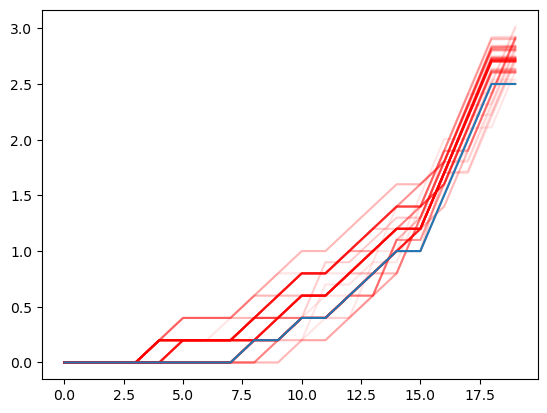

In [113]:
for t in t_opti :
    plt.plot(np.arange(0, 20, 1), np.cumsum(t), 'r', alpha = 0.1)
plt.plot(np.arange(0, 20, 1), np.cumsum(t_0))

Text(0.5, 1.0, 'evolution de la métrique de minimisation')

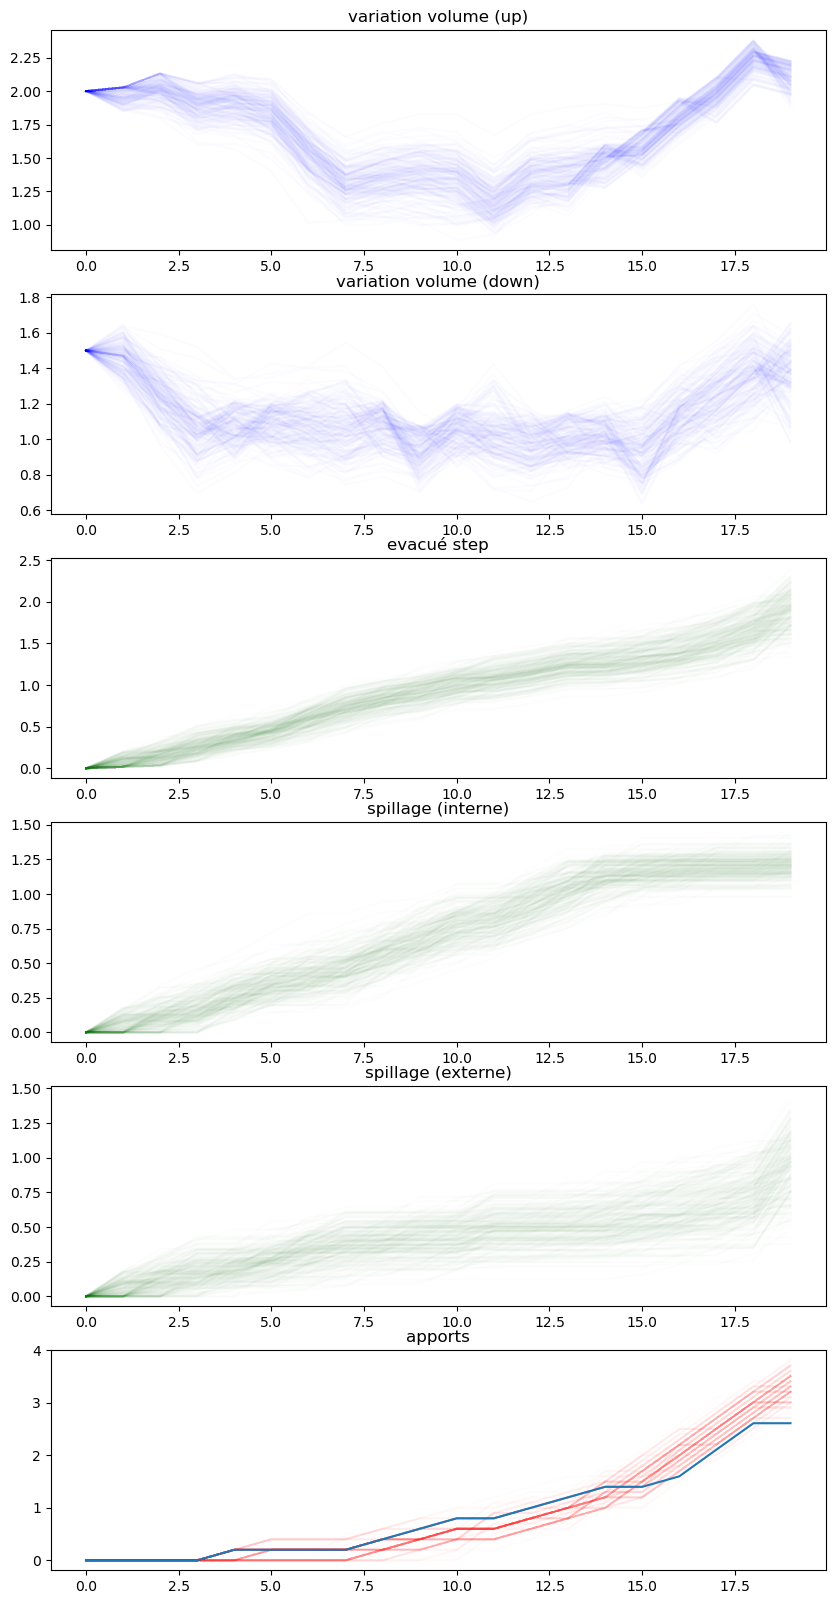

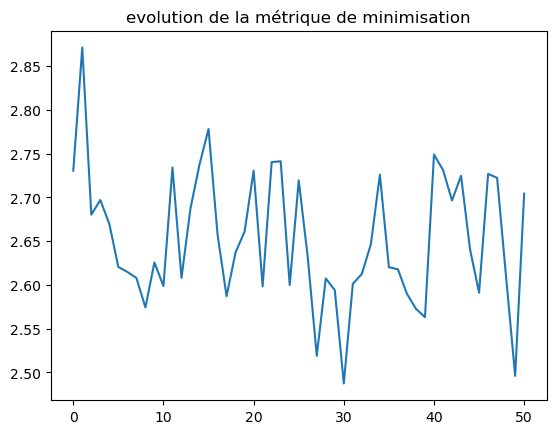

In [114]:
result = findTrajectories_parallel(
    upper_storage, lower_storage, new_traj[0], alpha, consigne_t_up, consigne_t_down, consigne_p, upper_var, lower_var, maxvar,
    iter=200, n_jobs= -1, show =True
)
plt.plot(np.arange(0, 20, 1), np.cumsum(result[1]))
plt.figure()
plt.plot(np.arange(0, len(m_evol), 1), m_evol)
plt.title("evolution de la métrique de minimisation")